# Time-Series Analysis

#### Modelling Corn Production in United States
---
### *Final Project for the Regression and Forecasting Technique Class*
---
Group Members:
- Gilbert Aurelio Sachio   (23101910047)
- Genta Ananda Putra Kharisma      (23101910001)
- Dennis Jonathan      (23101910027)
 
**Business Mathematics 2019**

According to [Britanica](https://www.britannica.com/plant/corn-plant), Corn (*Zea Mays*) is undeniably woven to the roots of our society.  There are a lot of uses of corn, such as food for the people, feed for livestocks, industrial uses, and in the coming age of renewable energy, as a component for biofuel. For this final project, our group decided to analyze whether the production of corn can be modelled using time-series methods. 

We will be focusing our analysis on the production of corn in the United States of America, in particular the national production of corn grain measured in Bushels abbreviated as Bu (a unit of volume). The dataset will be taken from surveys conducted by the United States Department of Agriculture which is available [here](https://quickstats.nass.usda.gov/results/44DFF224-E258-3602-BBEA-19D99AB01CCF) and we will be limiting the period from the year 1900 and 2020.

The analysis will be conducted using the programming language *Python* using the kernel available on [Deepnote](https://www.deepnote.com). We will also be utilising some libraries to help us in modelling the dataset.

## I. Prerequisites

### I.1. Installing the Libraries
There are some libraries that are not directly available on Deepnote's Python kernel, therefore we will  need to use the `!pip install` function to download and install the libraries that we will use for the analysis. This step is optional if and only need to be done once.

In [1]:
# Installing libraries
!pip install statsmodels
!pip install openpyxl
!pip install xlrd
!pip install pandas_datareader

### I.2. Importing the Libraries
We will now import the libraries that we will use for the analysis. There are three types of libaries that we will use, those are libraries to process and visualize the data, libraries to model time-series data, and finally libraries to asses those models. We will also be ignoring warning popups as well as setting plots to appear inline with the plot theme 'darkgrid' from the `seaborn` library.

In [2]:
# Importing the data processing and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import seaborn as sns

# Importing time-series modelling libraries
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import Holt, SimpleExpSmoothing

# Importing model assesment metrics libraries
from scipy.stats.distributions import chi2
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.stattools as sts 
from scipy.stats import normaltest, skew, kurtosis

# Shutting off warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
%matplotlib inline
sns.set_style('darkgrid')

### I.3. Importing the Data
We will now import the the data into our workspace. The data is available from the file `CORN, GRAIN - PRODUCTION, MEASURED IN BU -US.csv` which we can import using the function `pd.read_csv()` because the data is in the form of *Comma Separated Values* from the `pandas` library.

In [3]:
# Importing the dataset
data =  pd.read_csv('dataset.csv')

# Previewing the dataset
data.head()

Program  Year Period  Week Ending Geo Level     State  State ANSI  \
0  SURVEY  1866   YEAR          NaN  NATIONAL  US TOTAL         NaN   
1  SURVEY  1867   YEAR          NaN  NATIONAL  US TOTAL         NaN   
2  SURVEY  1868   YEAR          NaN  NATIONAL  US TOTAL         NaN   
3  SURVEY  1869   YEAR          NaN  NATIONAL  US TOTAL         NaN   
4  SURVEY  1870   YEAR          NaN  NATIONAL  US TOTAL         NaN   

   Ag District  Ag District Code  County  ...  Zip Code  Region  \
0          NaN               NaN     NaN  ...       NaN     NaN   
1          NaN               NaN     NaN  ...       NaN     NaN   
2          NaN               NaN     NaN  ...       NaN     NaN   
3          NaN               NaN     NaN  ...       NaN     NaN   
4          NaN               NaN     NaN  ...       NaN     NaN   

   watershed_code  Watershed  Commodity  \
0               0        NaN       CORN   
1               0        NaN       CORN   
2               0        NaN       CORN   
3               0        NaN       CORN   
4               0        NaN       CORN   

                                  Data Item Domain Domain Category  \
0  CORN, GRAIN - PRODUCTION, MEASURED IN BU  TOTAL   NOT SPECIFIED   
1  CORN, GRAIN - PRODUCTION, MEASURED IN BU  TOTAL   NOT SPECIFIED   
2  CORN, GRAIN - PRODUCTION, MEASURED IN BU  TOTAL   NOT SPECIFIED   
3  CORN, GRAIN - PRODUCTION, MEASURED IN BU  TOTAL   NOT SPECIFIED   
4  CORN, GRAIN - PRODUCTION, MEASURED IN BU  TOTAL   NOT SPECIFIED   

           Value CV (%)  
0    730,814,000    NaN  
1    793,905,000    NaN  
2    919,590,000    NaN  
3    782,084,000    NaN  
4  1,124,775,000    NaN  

[5 rows x 21 columns]

### I.4. Selecting the Useful Columns for Analysis
As mentioned before, we will be analyzing data from the year 1900 up to and including 2020, thus we will be slicing our dataframe to only include rows from those corresponding years. We will also be removing some columns that are not useful for our analysis (simply every column except `Year` and `Value`).

In [4]:
# Selecting the useful columns from the dataset
df = data[['Year','Value']]
df = df[df['Year']>=1900]

# Previewing the selection
df.head()

Year          Value
34  1900  2,661,978,000
35  1901  1,715,752,000
36  1902  2,773,954,000
37  1903  2,515,093,000
38  1904  2,686,624,000

## II. Data Exploration

### II.1. Getting the Dataframe's Dimension

In [5]:
# Previewing the data dimension
print('The data has {p1} rows and {p2} columns'.format(p1 = df.shape[0], p2 = df.shape[1]))

The data has 121 rows and 2 columns


Our dataset has $121$ rows and $2$ columns, thus we have a confirmation that our slicing and removal of some unnecessary columns has indeed been successful. Those columns are:
- `Year` --> the year of the entry (from 1900 - 2020)
- `Value` --> the corn production value in Bushels (Bu)

### II.2. Setting the Frequency and Cleaning
Since we are working with time-series data, we can set our dataframe index as the time when the data was entered (also a way to reduce the dimension of the dataframe). Our data was entered yearly thus we can use the function `pd.to_datetime()` using the parameter `format = '%Y'` (indicating the yearly format. After that, we will replace the index and setting the index frequency in a yearly interval at the beginning of the year (1-1-YYYY instead of 12-31-YYYY) and backfilling data if there are indeed null values.

We also need to clean our `Value` column which we need to convert into numerics (the current format is in `object` type which we cannot use to model). To do this, we will need to replace commas from the entries and setting `.astype(int)` to transform it into integers.

In [6]:
# Converting the year into datetime
df['Year'] = pd.to_datetime(df['Year'],format = '%Y')

# Setting the index to year
df.set_index('Year',inplace = True)

# Replacing commas in Value
df.Value = df.Value.str.replace(',','').astype(np.int64)

# Setting index frequency and backfilling the data if there is any nan
df = df.sort_index().asfreq('AS',method = 'bfill') # AS --> Year Start, A --> year end

# Previewing the changes
df.head(5)

Value
Year                  
1900-01-01  2661978000
1901-01-01  1715752000
1902-01-01  2773954000
1903-01-01  2515093000
1904-01-01  2686624000

#### II.3. Checking for Nulls
As mentioned in the previous section, we have filled null values using backfill (filling null using  the value of the previous entry), thus we will be expecting to have no null values left. To confirm this hypothesis, we can use `isnull().sum()`.

In [7]:
# Checking the null data
df.isnull().sum()

Value    0
dtype: int64

Our hypothesis has been confirmed as there are no null values in our dataframe, which also means that the backfill has indeed worked according to plan.

### II.4. Checking the Datatype

In [8]:
# Checking the column datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 1900-01-01 to 2020-01-01
Freq: AS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Value   121 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


From the `df.info()` method we can see that the data have $121$ entries/rows starting from the year $1900$ up to and including $2020$. The data types for the one and only column is already numerical datatype, making it relatively easier to analyze, graph plots and aggregate the data.

### II.5. Descriptive Statistics
We will explore the data by inspecting the descriptive statistics from the data we have. Descriptive statistics that can be checked are:

1. Amount of Data
2. Average
3. Standard Deviation
4. Minimum data
5. Quartile $1$-$3$
6. Maximum data

We can use the `.describe()` function to easily generate descriptive statistics.

In [9]:
# Descriptive statistics
df.describe()

Value
count  1.210000e+02
mean   5.532430e+09
std    3.858118e+09
min    1.146734e+09
25%    2.577449e+09
50%    3.597803e+09
75%    8.118650e+09
max    1.514804e+10

From the descriptive statistics, we can see that:
-  There are $121$ entries.
- The average production of corn is roughly $5,532,430,438 \space \text{Bu}$ and the median is roughly $3,858,118,412 \space \text{Bu}$ which is a sign of positive skew distribution.
- The minimum production is $1,146,734,000 \space \text{Bu}$ while the maximum is $15,148,038,000 \space \text{Bu}$.

### II.6. Plotting the Dataset
We will now plot the dataset to see whether there are discerning paterns of our time-series data. We will use the function `plt.plot()` from the library `matplotlib.pyplot`.

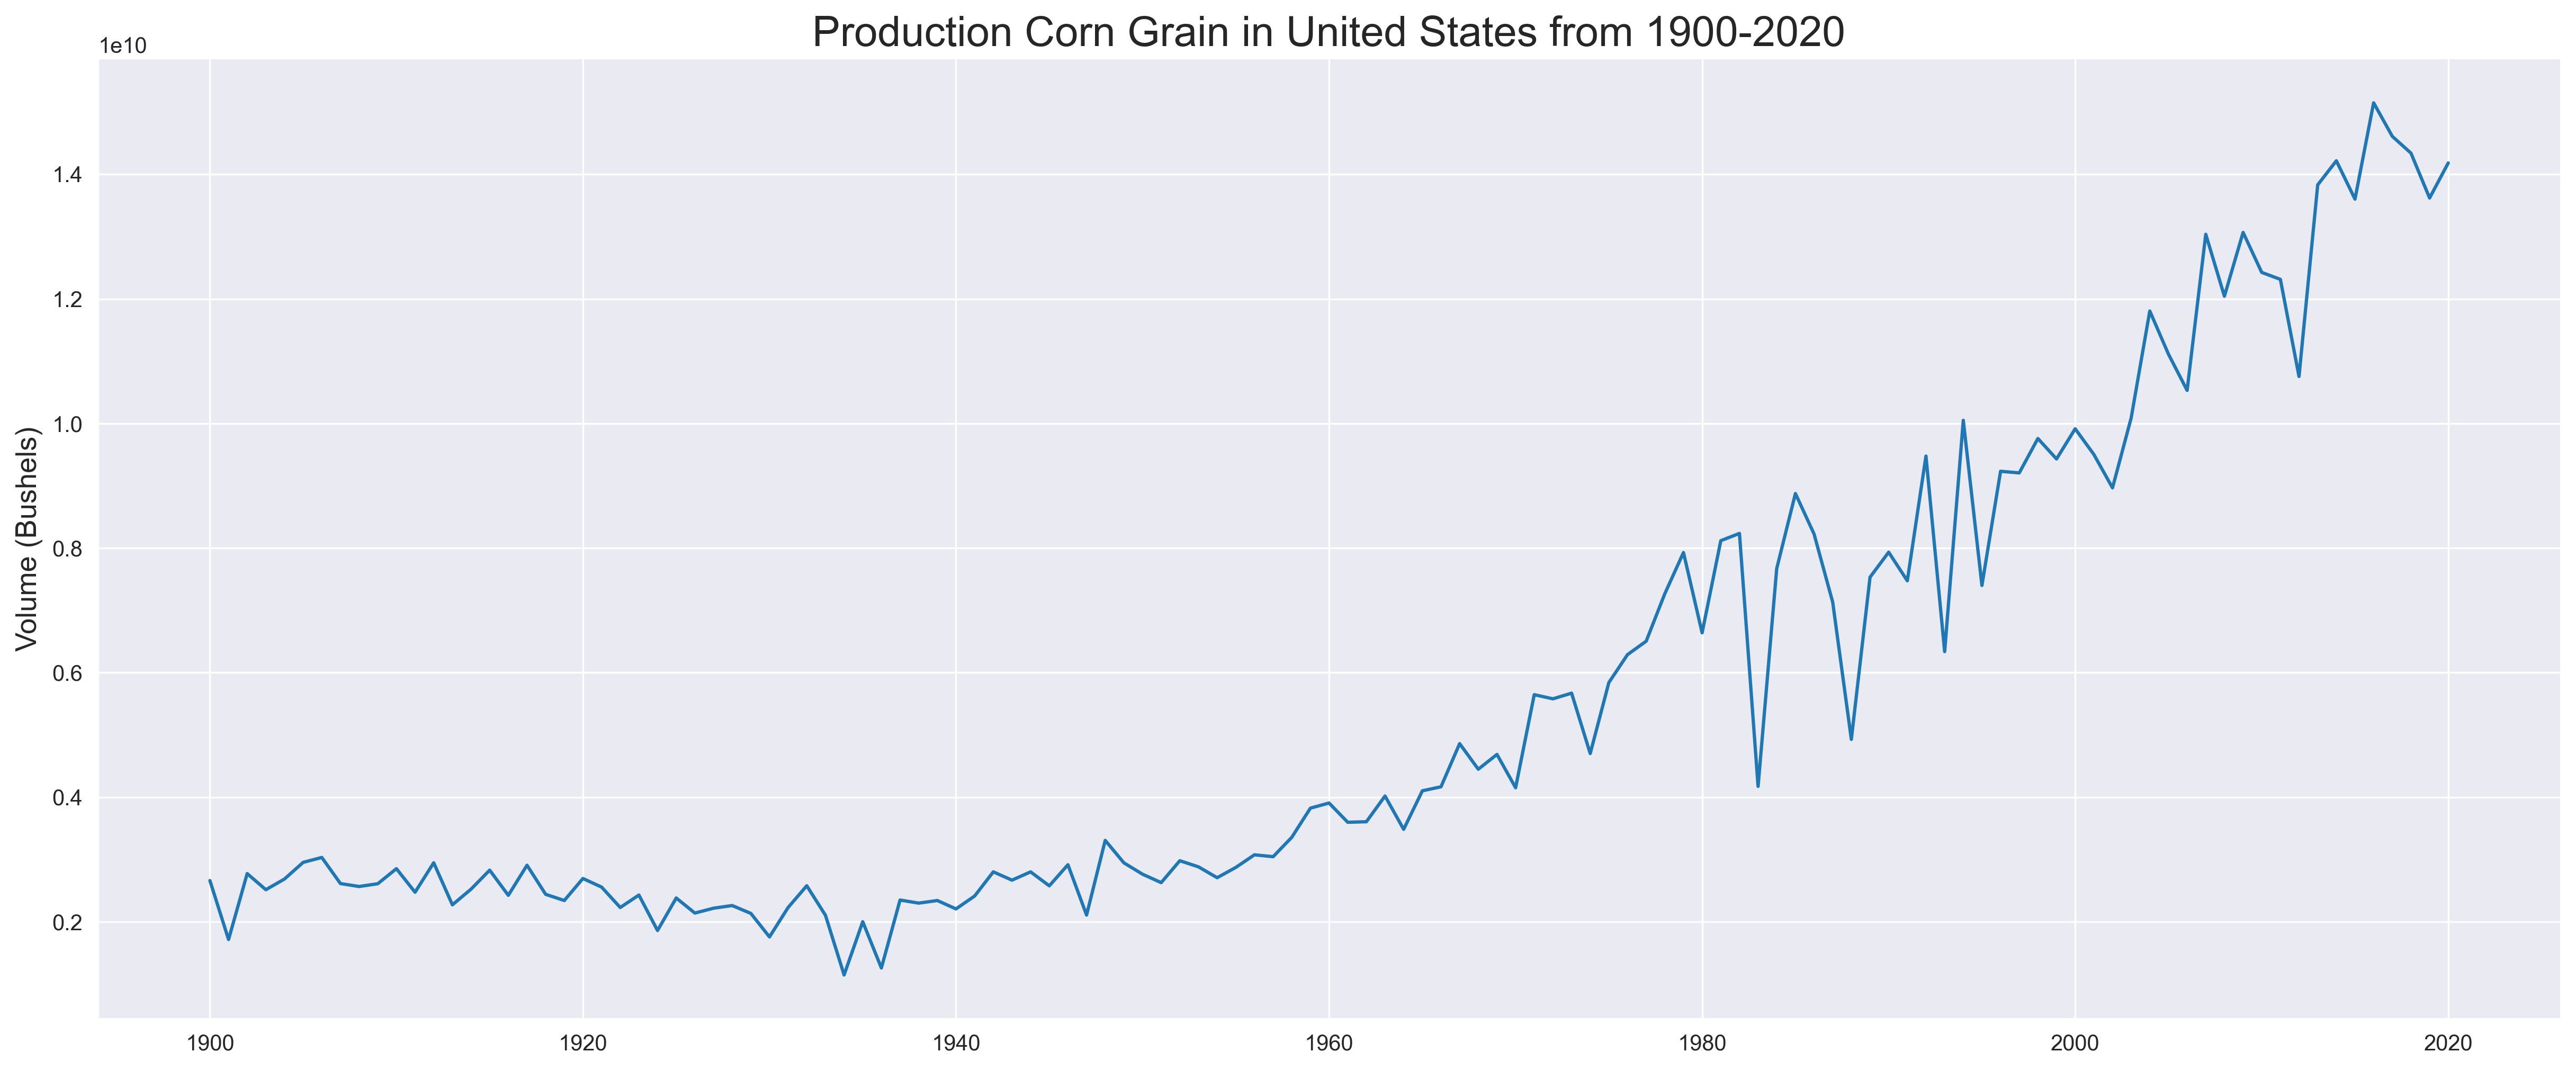

In [10]:
# Plotting the Value column
plt.figure(figsize = (20,8), dpi = 300)
plt.plot(df['Value'])

# Plot Settings
plt.title('Production Corn Grain in United States from 1900-2020', fontsize = 19)
plt.ylabel('Volume (Bushels)', fontsize = 13)
sns.despine() 

The plot shows that there is a clear upward trend on our data. Upon quick observation, there is no distinct cyclical or seasonal patern, but we will need to decompose the data to confirm the result. We can also see that the data is probably not stationary thus we will need to differencing to try and solve this issue (or alternatively use models which accounts differencing).

### II.7. Checking the Data Distribution
We will check the distribution of the data using **Normal Q-Q plot** (Quantile - Quantile Plot). If the distribution of the points follows the reference line, it can be said that the data held is normally distributed. To be able to find **Q-Q plot**, we use the `sm.qqplot()` function from the library `statsmodels.api`.

We can also use **Kernel Density Estimate plot** to see the exact distribution of the dataset. The function to do so is `sns.kdeplot()` which is taken from the `seaborn` library.

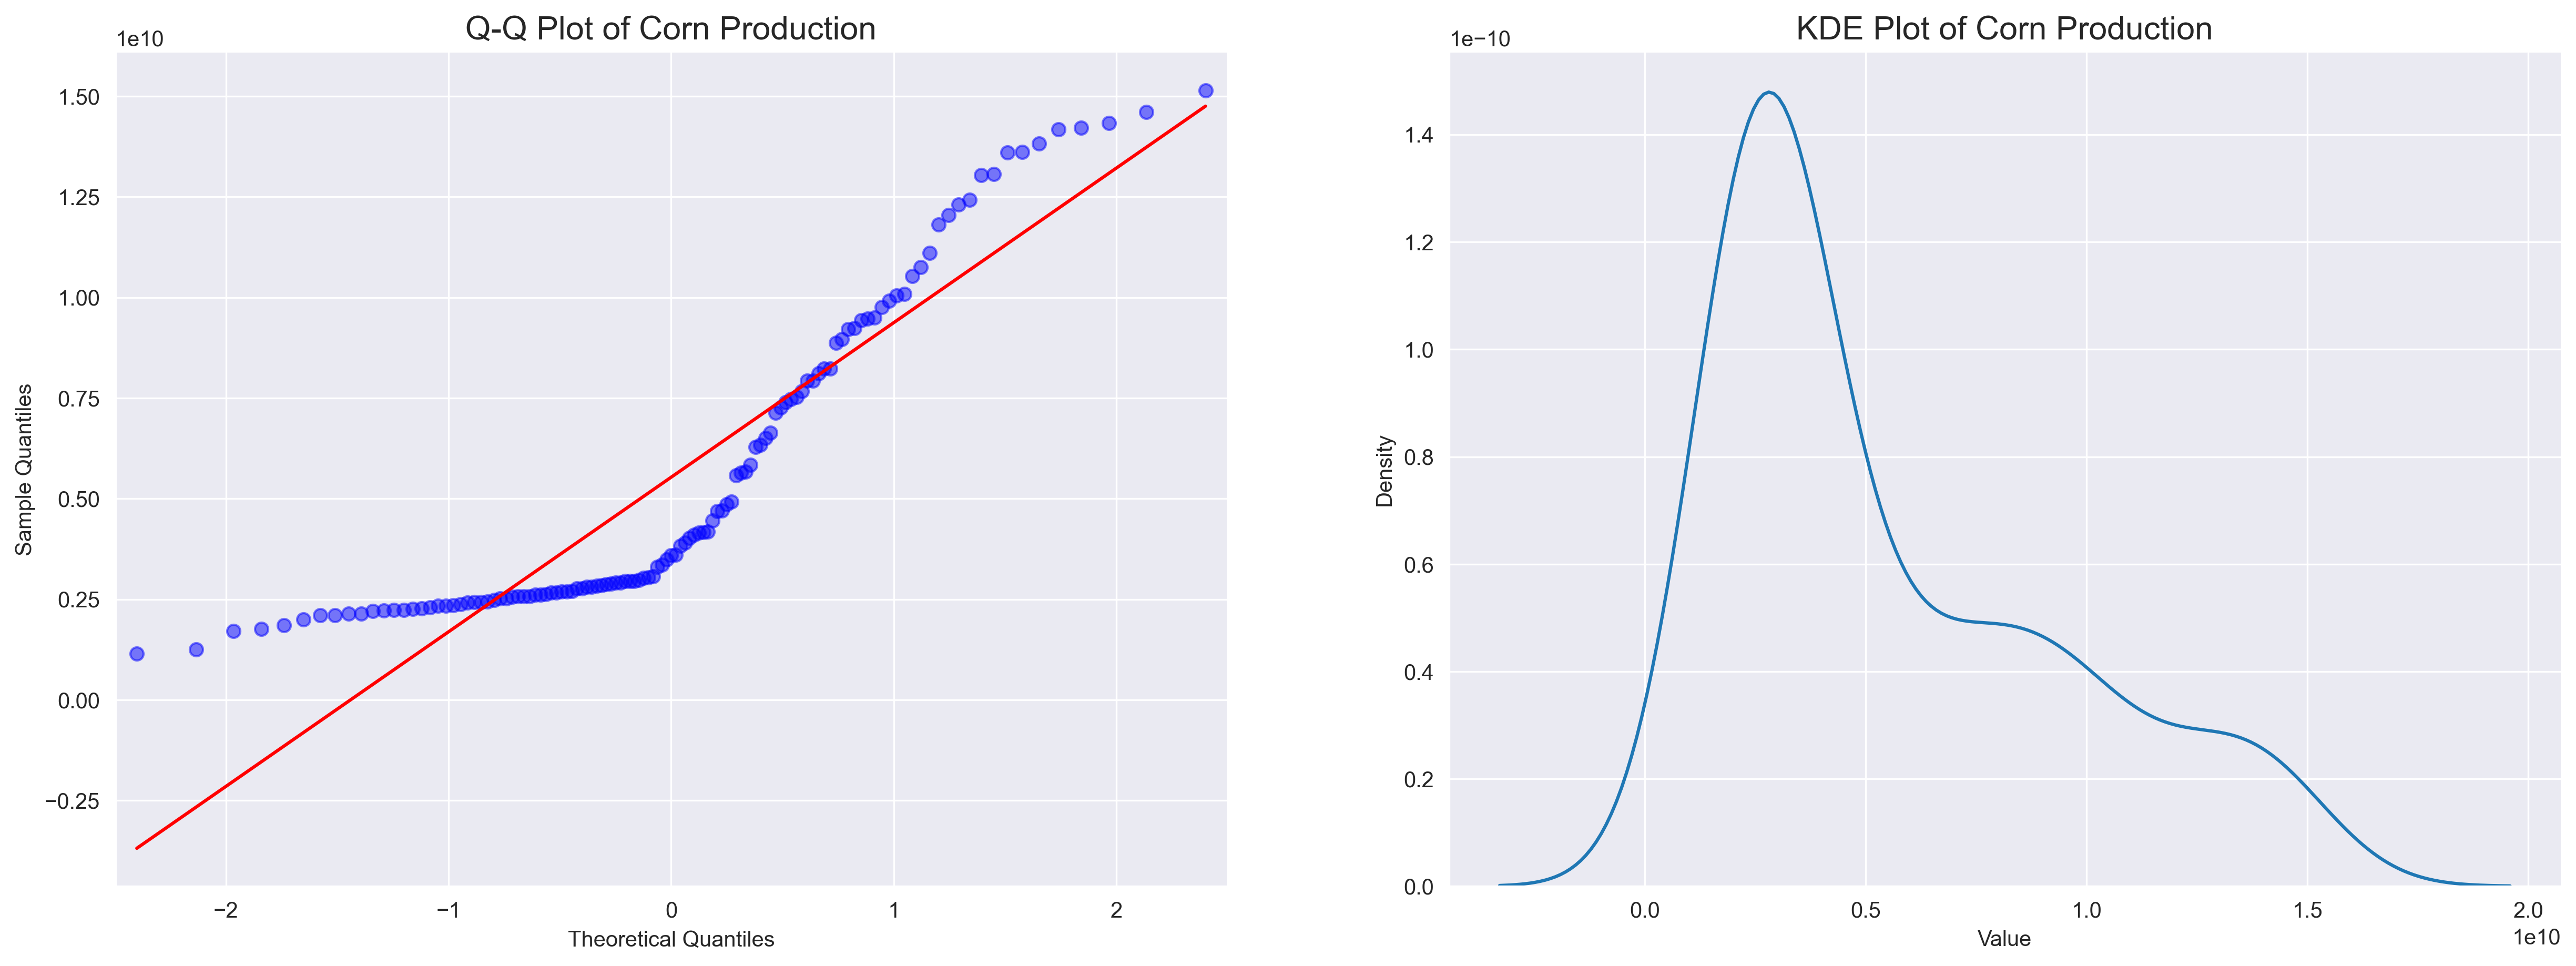

In [11]:
# Plotting the distribution
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,7), dpi = 300)
sm.qqplot(df['Value'],line='s',ax=ax1,alpha=0.5)
sns.kdeplot(df['Value'])

# Plot settings
ax1.set_title('Q-Q Plot of Corn Production',fontsize = 15)
ax2.set_title('KDE Plot of Corn Production', fontsize = 15)
sns.despine()

From the two plots above, we can clearly see that our data has a right skew (confirming our guess by looking at the median and the mean). The data does not follow the **Q-Q plot** reference line perfectly, thus according [Varshney](https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0), the data is not normally distributed, rather it is right skewed and has a lot of data on the tail of the distribution.

### II.8. Stationarity Testing
Checking for stationarity is an important step in time series analysis. One of the ways we can achieve this is to use the **Augmented Dickey-Fuller Test**  or also referred as the **Unit Root Test**. This test is available from the library `statsmodels.tsa.stattools` using the function `adfuller()`.

<br><b>Hypothesis testing for stationarity:</b><br>
$H_{0}: \text{The data is not stationary}$ <br>
$H_{a}: \text{The data is stationary}$ <br>
<br><b>Decision Rule:</b> <br> 
$H_{0}$ is rejected if $P\text{-value} < \alpha = 0.05$. <br>

In [12]:
# Checking the stationarity of the data set
print('The p-value of the Augmented Dickey-Fuller test is {}'.format(sts.adfuller(df.Value)[1]))

The p-value of the Augmented Dickey-Fuller test is 0.9990687979102963


The result of the **Augmented Dickey-Fuller Test** is a $\text{p-value}\approx 1$ thus we cannot reject $H_0$, confirming our suspicion that the data is not stationary. We try to difference the data to make the data stationary.

In [13]:
# Differencing the data
df['Diff'] = df.Value.diff(periods = 1)

# Checking the stationarity of the differenced data
print('The p-value of the Augmented Dickey-Fuller test is {}'.format(sts.adfuller(df.Diff.dropna())[1]))

The p-value of the Augmented Dickey-Fuller test is 4.408202745563027e-14


The result of the **Augmented Dickey-Fuller Test** is a $\text{p-value}\approx 0$ thus we can reject $H_0$, therefore after doing differencing once, the data is already stationary.

### II.9. Seasonal Decomposition
Seasonal decomposition is a tool which we can use to separate some components out from our dataset, namely **seasonal pattern**, **trend pattern**, and **noise**. We can easily do this using the function `seasonal_decompose()` from the library `statsmodels.tsa.seasonal`. Because our data can be categorized into additive model, we will set the parameter `model = 'addition'`  in the function we are using.

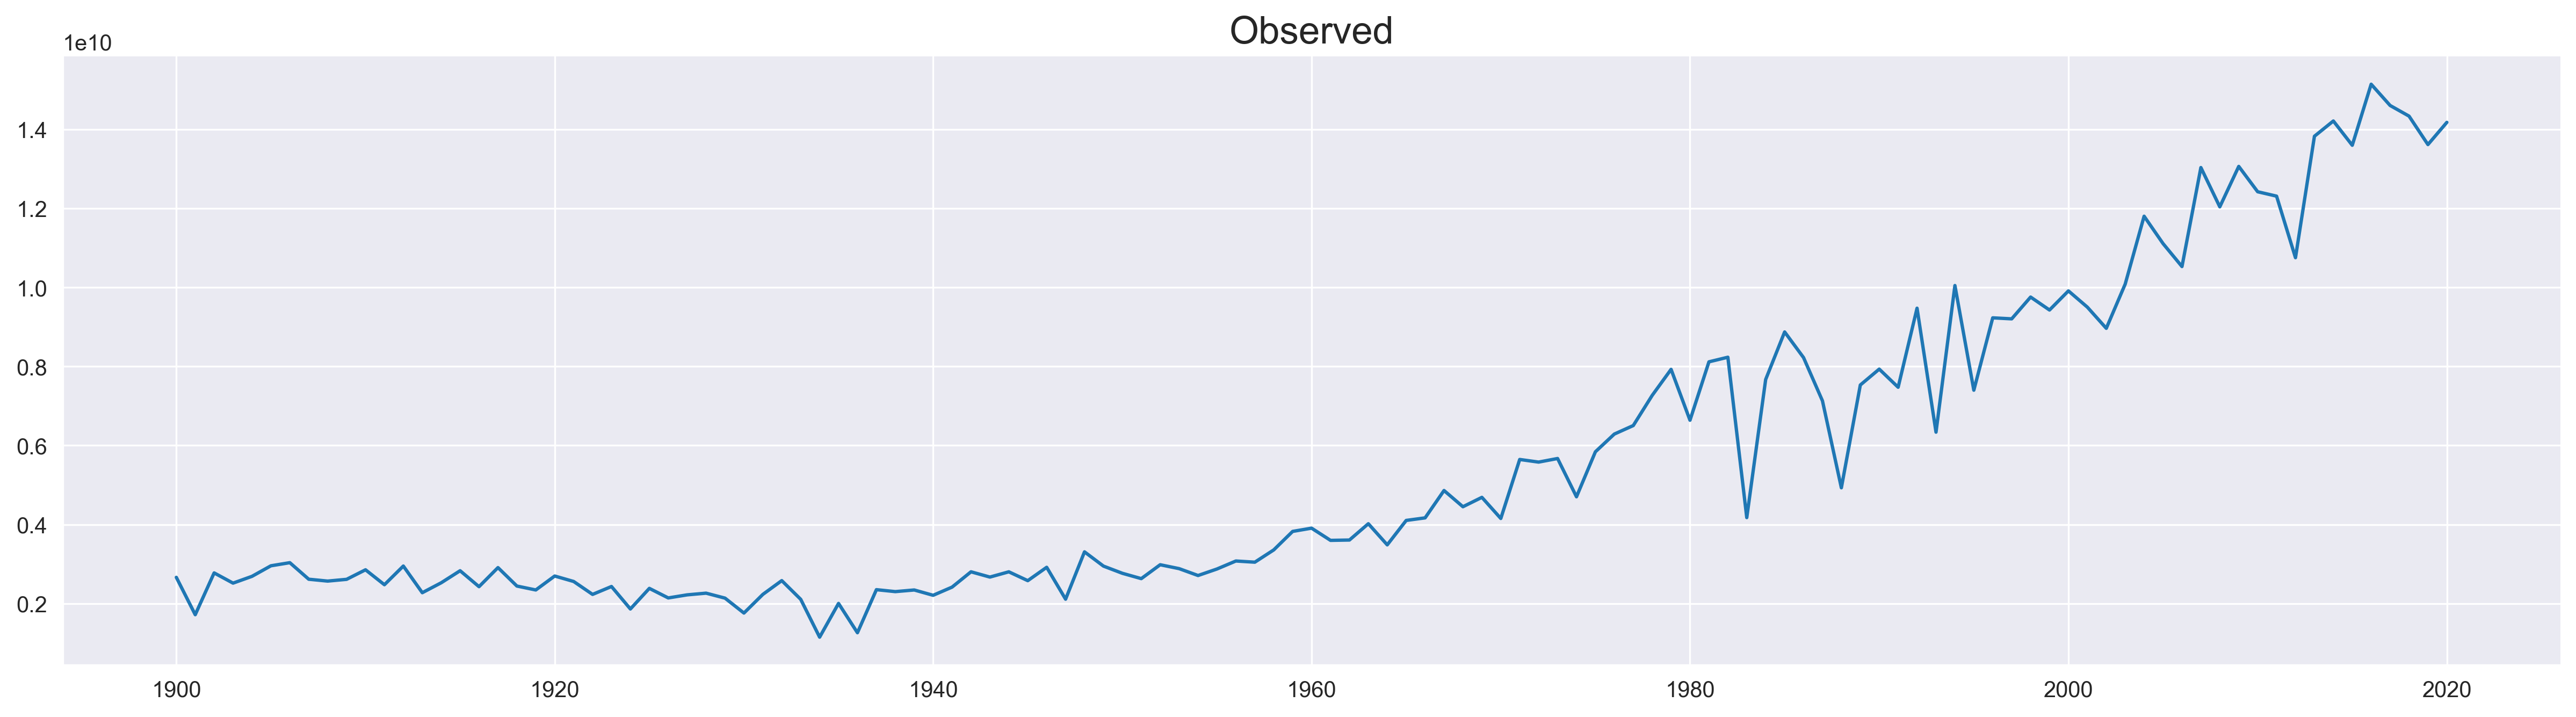

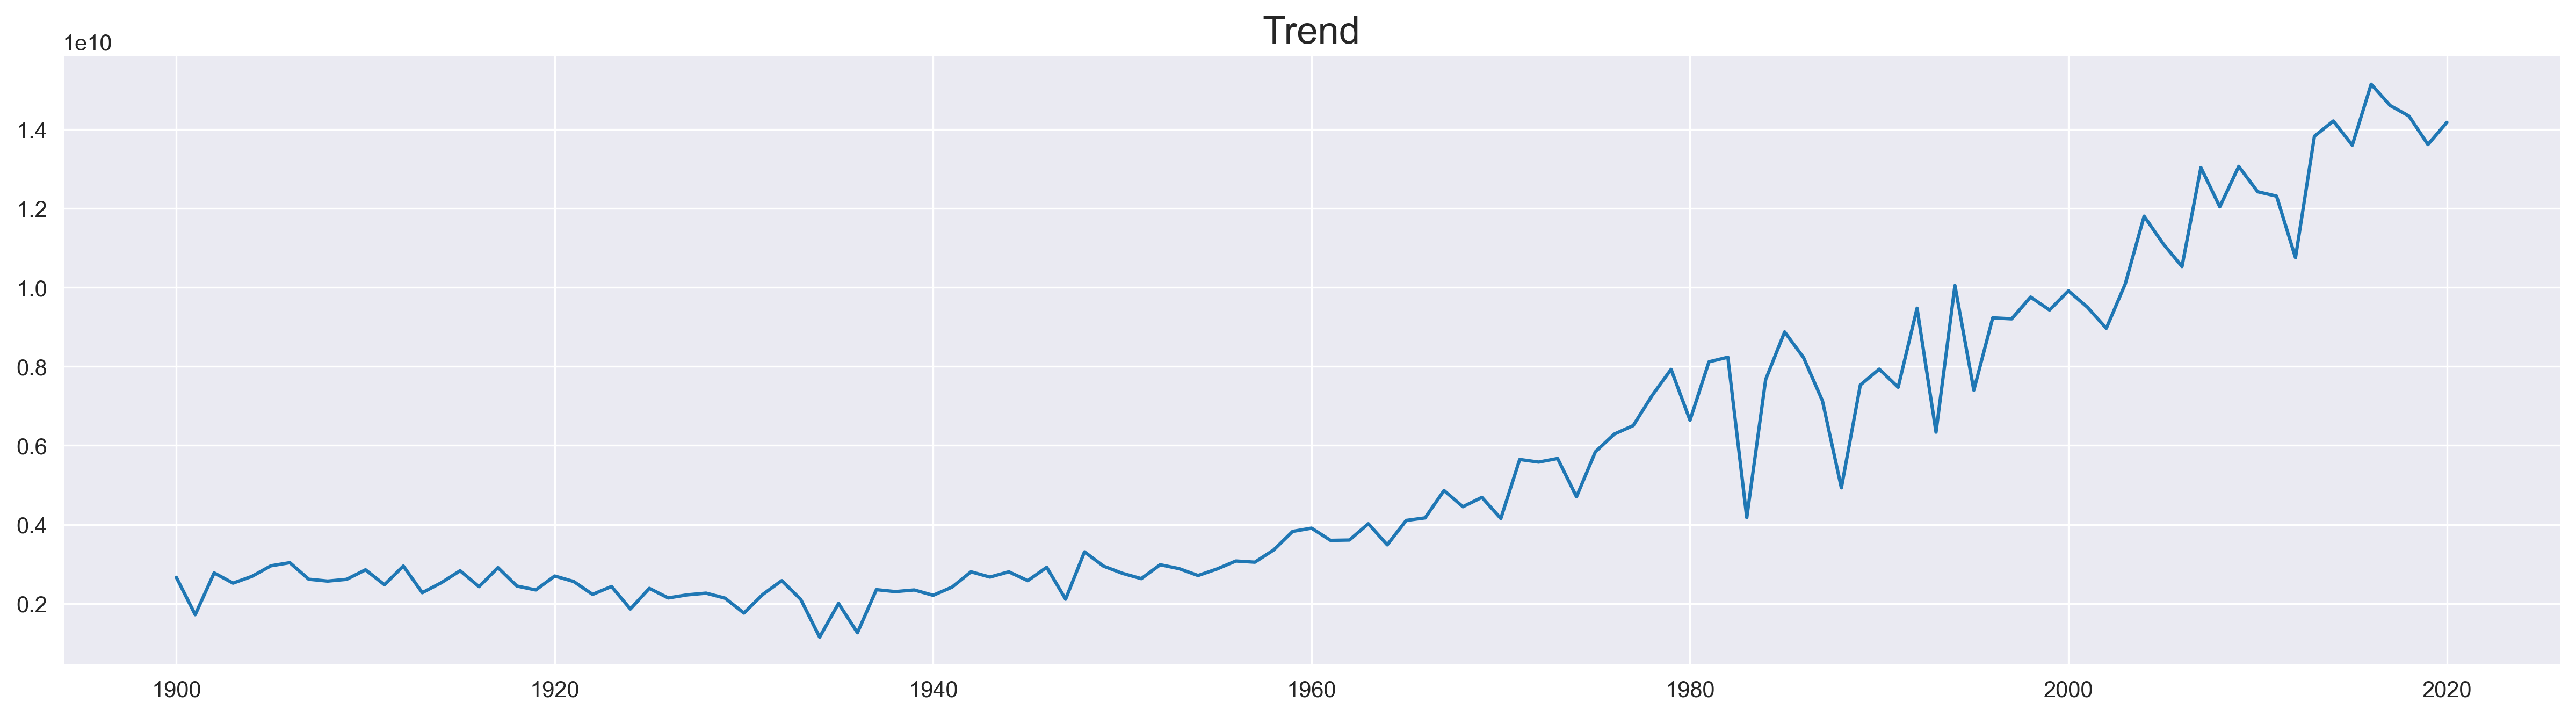

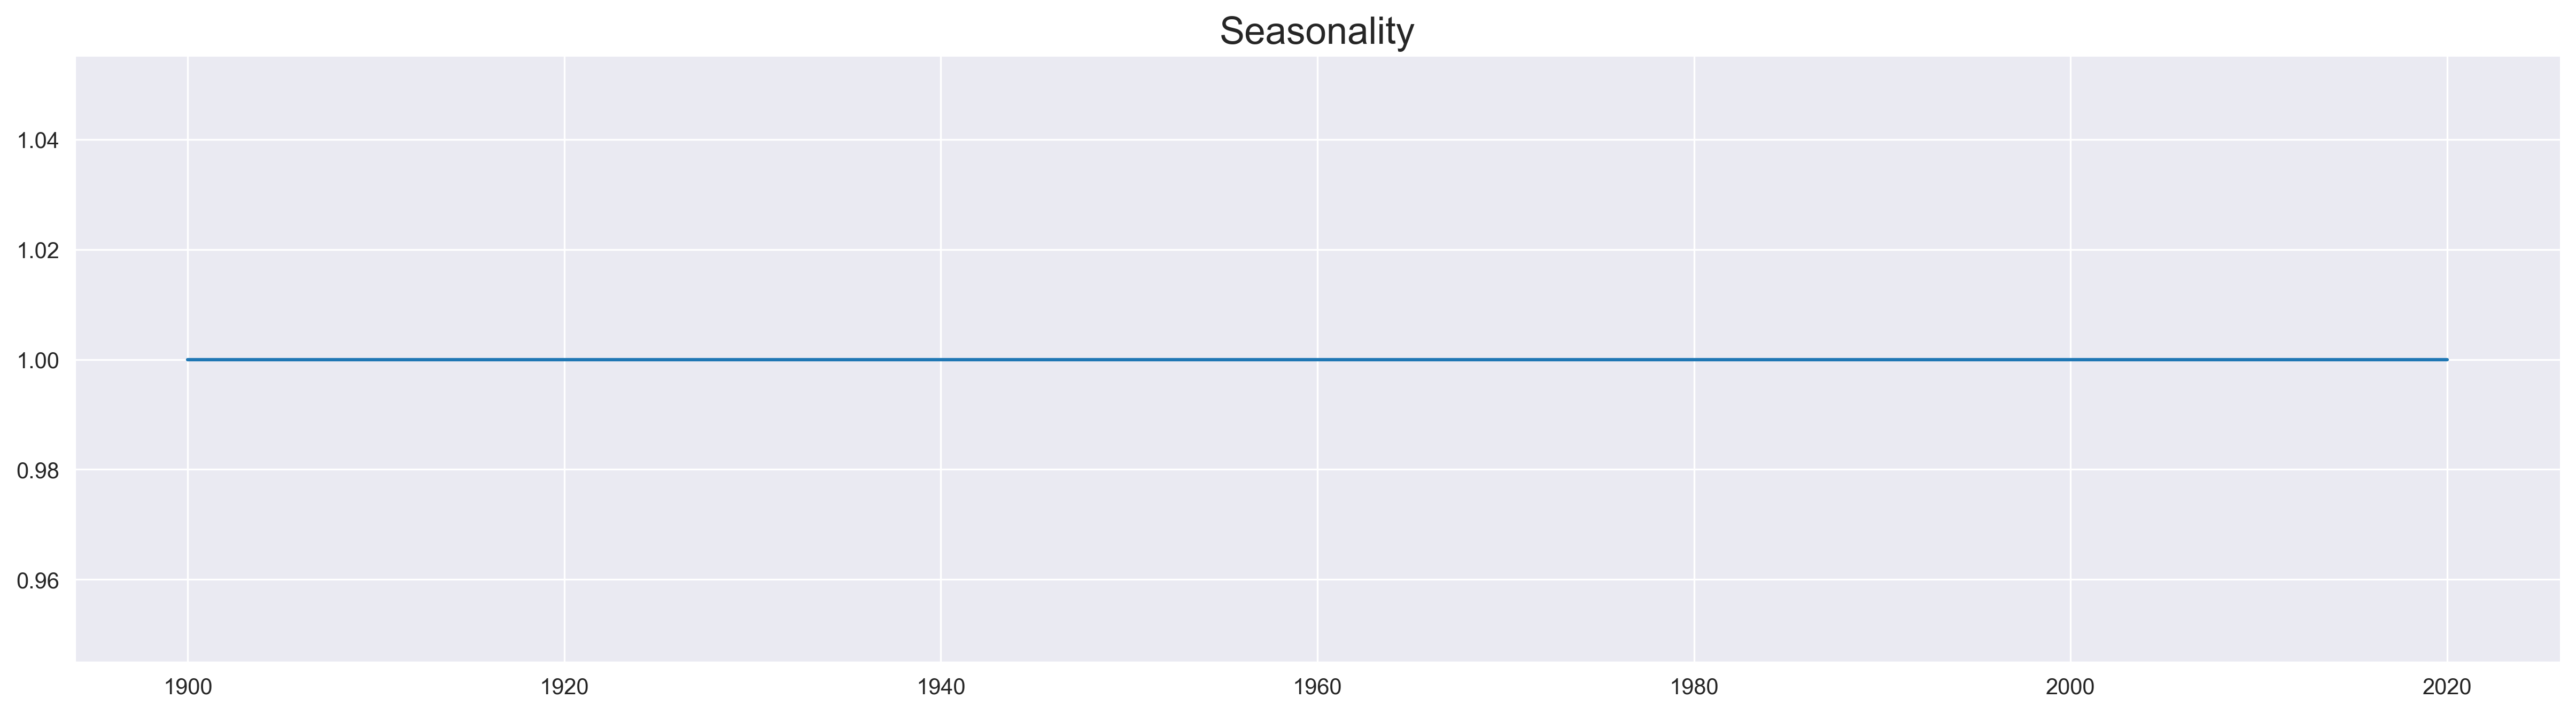

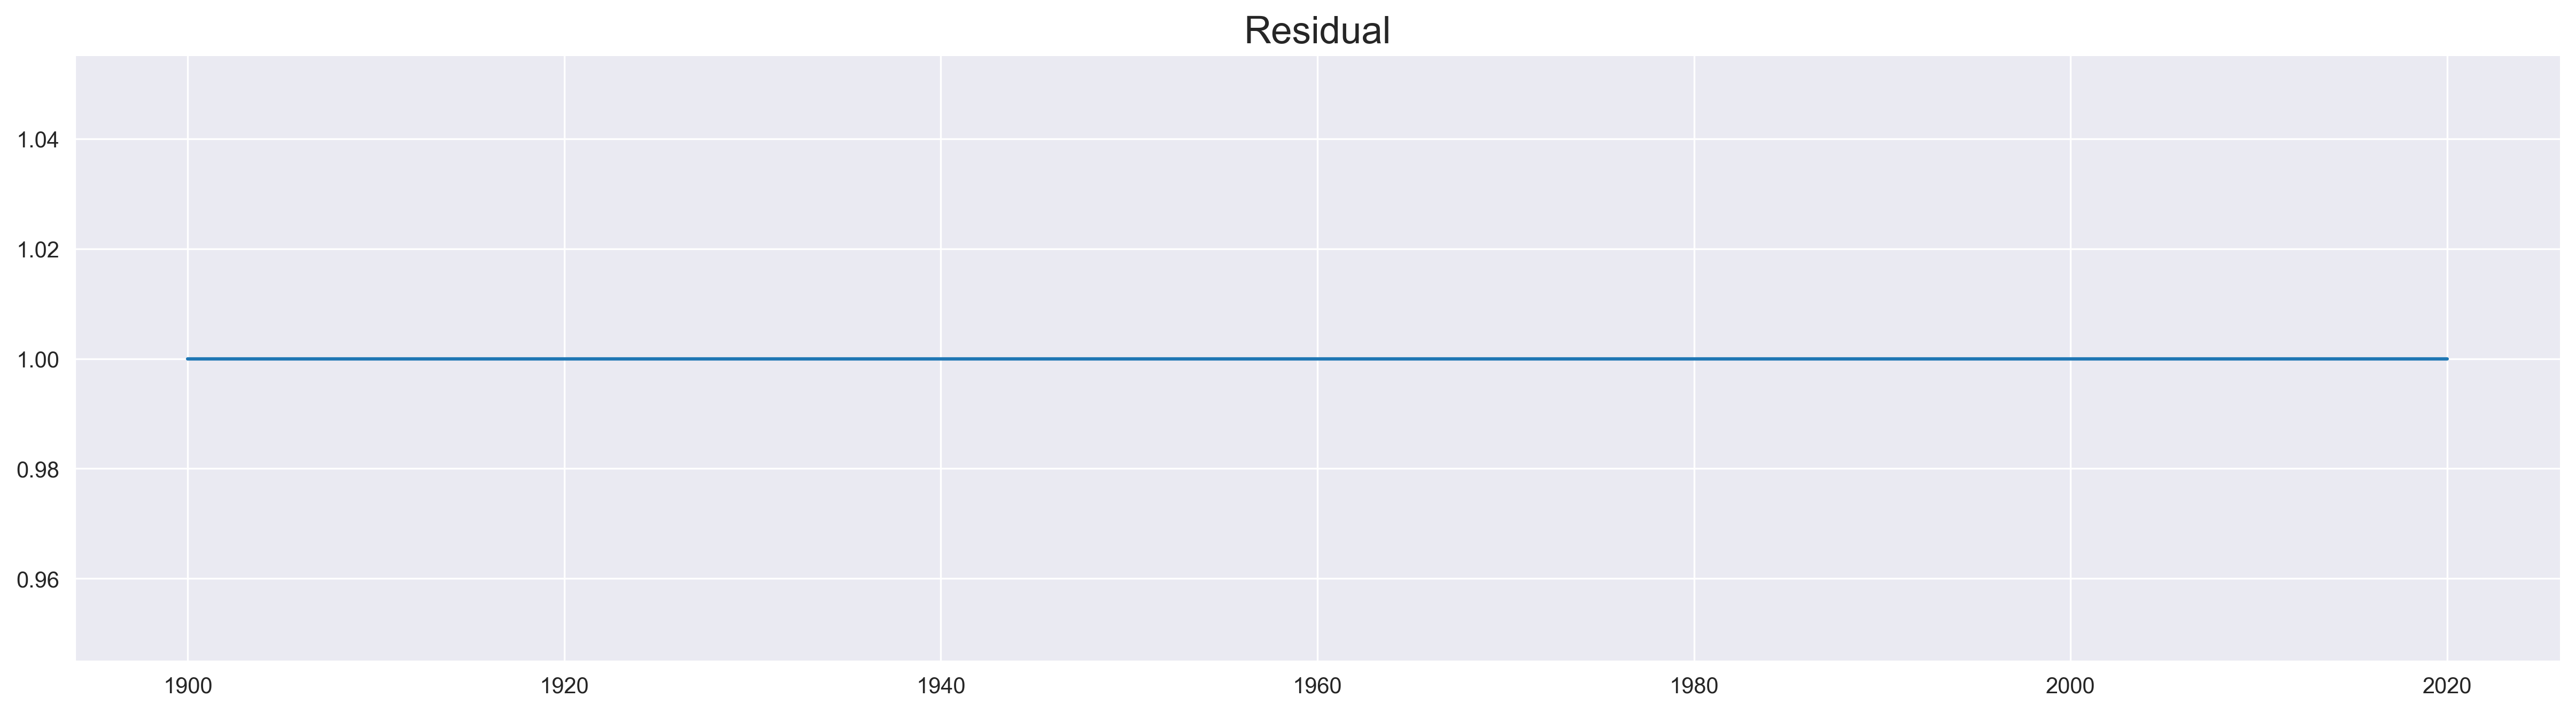

In [14]:
# Performing seasonal decomposition to the dataset
result = seasonal_decompose(df.Value, model = 'mul')

# Plotting the result
titles = ['Observed','Trend','Seasonality','Residual']
title_index = 0
for dec in (result.observed, result.trend, result.seasonal, result.resid):
    plt.figure(figsize = (20,5), dpi = 300)
    plt.plot(dec)
    plt.title(titles[title_index], fontsize = 17)
    sns.despine()
    title_index += 1

The plots above showed that there is indeed  no **seasonal pattern**  in our data, but there is a positive **trend pattern**. The function also did not managed to separate the **noise** from our dataset. The **seasonal pattern** and also the **trend pattern** seems to be based on the multiplicative model.

### II.10. Volatility
Volatility is a measure which is commonly found in trading e.g. stocks, options. [Investopedia](https://www.investopedia.com/terms/t/time-varying-volatility.asp) defines volatility as  how much a value swings around the the mean of the value. In this analysis, we will not be doing anything to model the volatility, but it is a good thing to know how volatile our data really is.

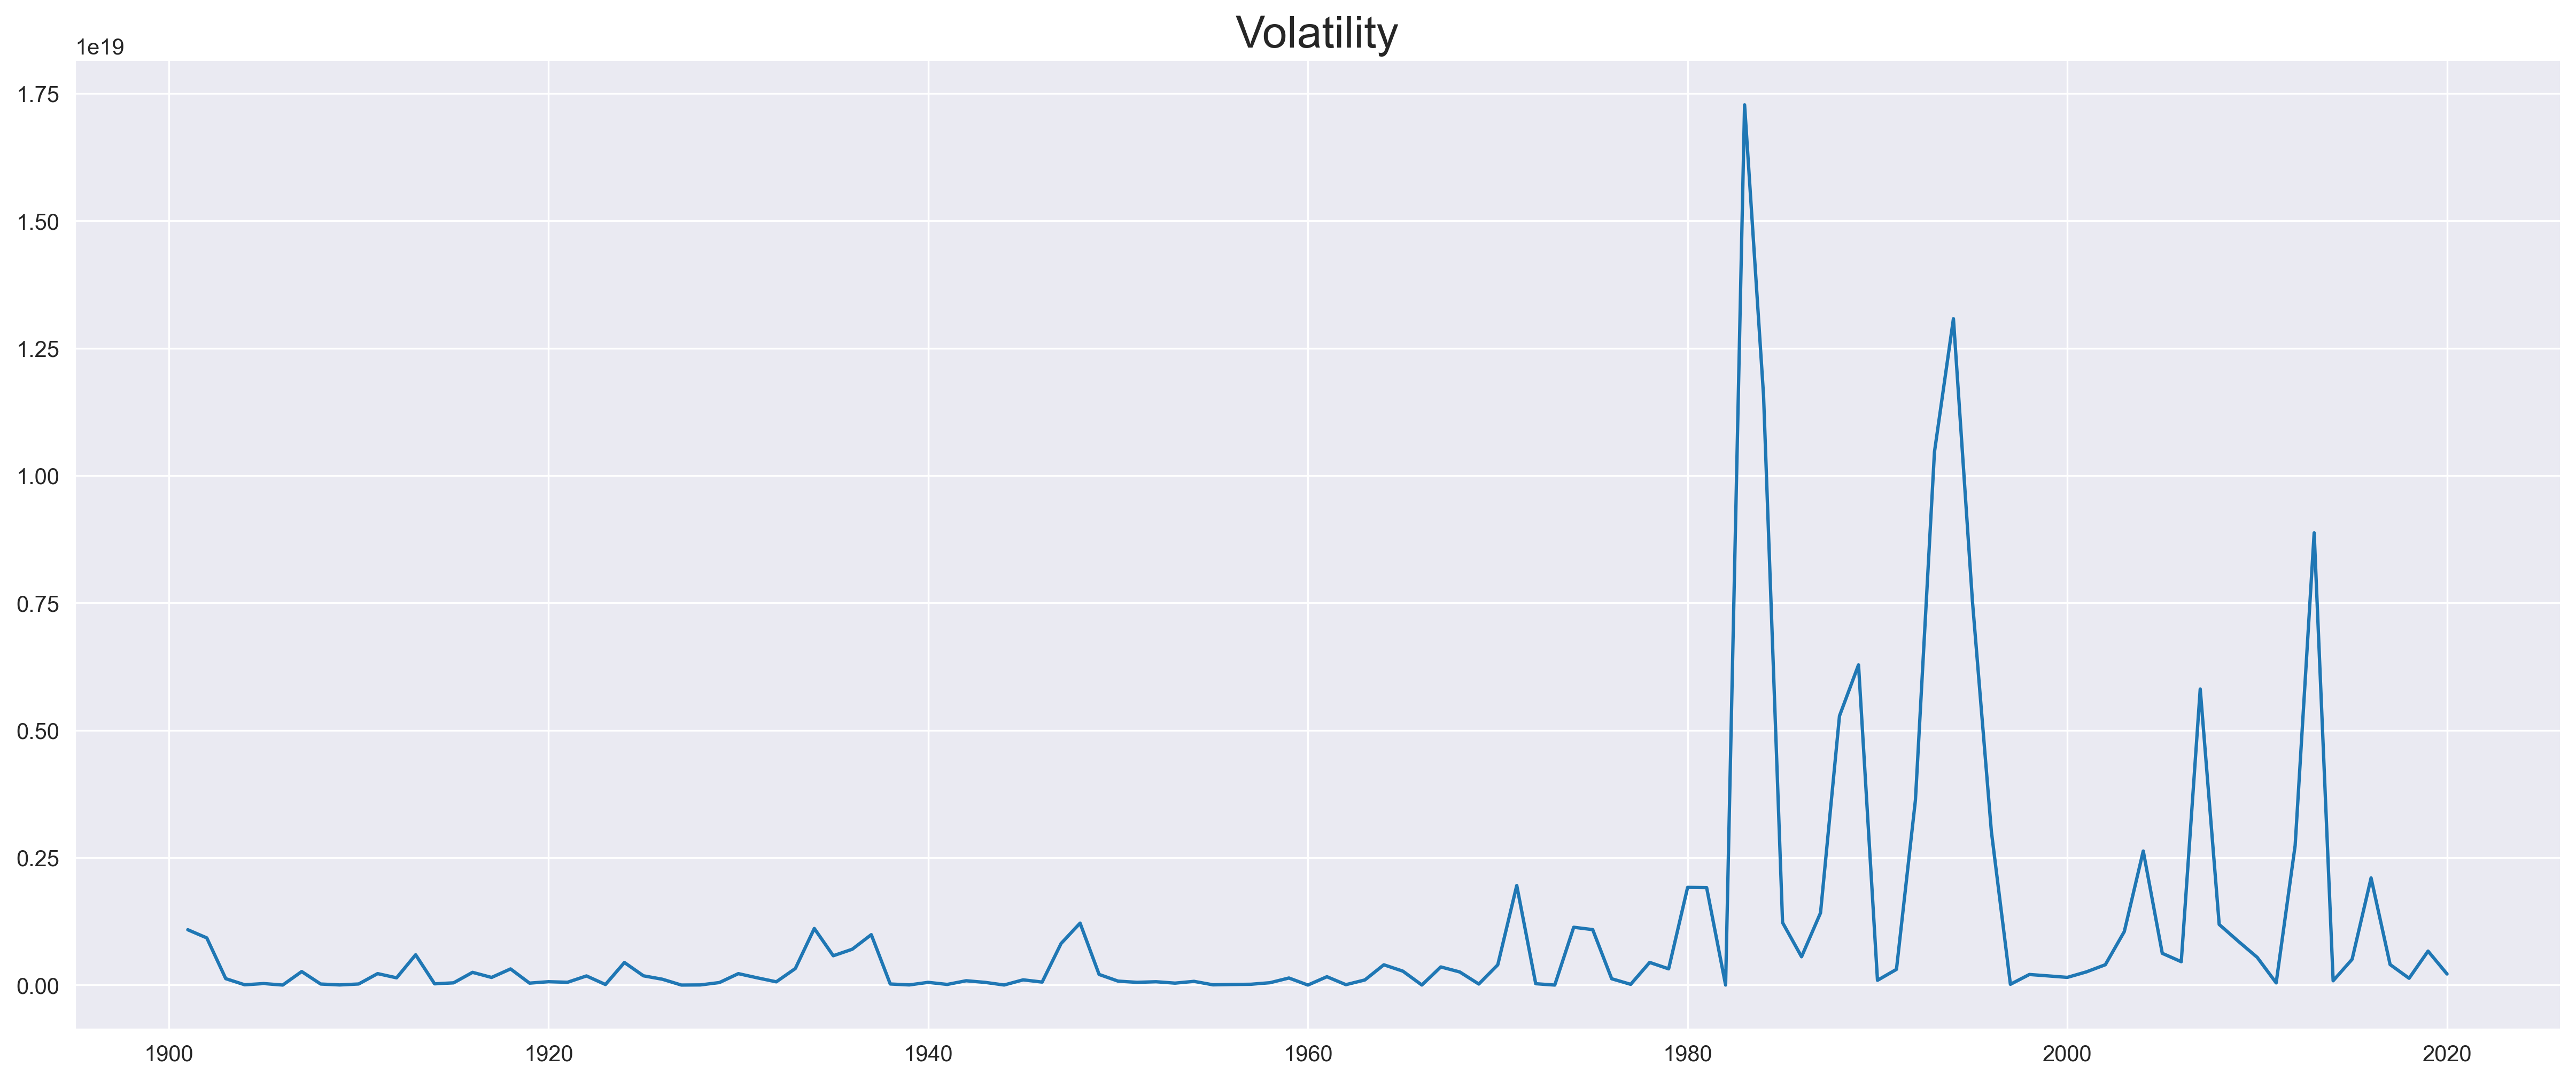

In [15]:
# Plotting volatility
plt.figure(figsize=(20,8), dpi = 300)
plt.plot((df.Diff.dropna()-df.Diff.dropna().mean())**2)

# Plot settings
plt.title("Volatility", size = 20)
sns.despine()
plt.show()

We can see that after the year 1980, our data is very volatile and data before 1980 is generally quite stationary. This is indicated in the greater magnitude spikes on our plot compared to data before 1980. We can also see from our original plot of the data in section **II.6.** that the data goes up and down very rapidly.

## III.Exponential Smoothing

### III.1. Simple Exponential Smoothing
We will try and model our data using the **Simple Exponential Smoothing**. This method is suitable for data which does not have any **trend** or **seasonal** pattern, thus the presence of the only variable $\alpha$.

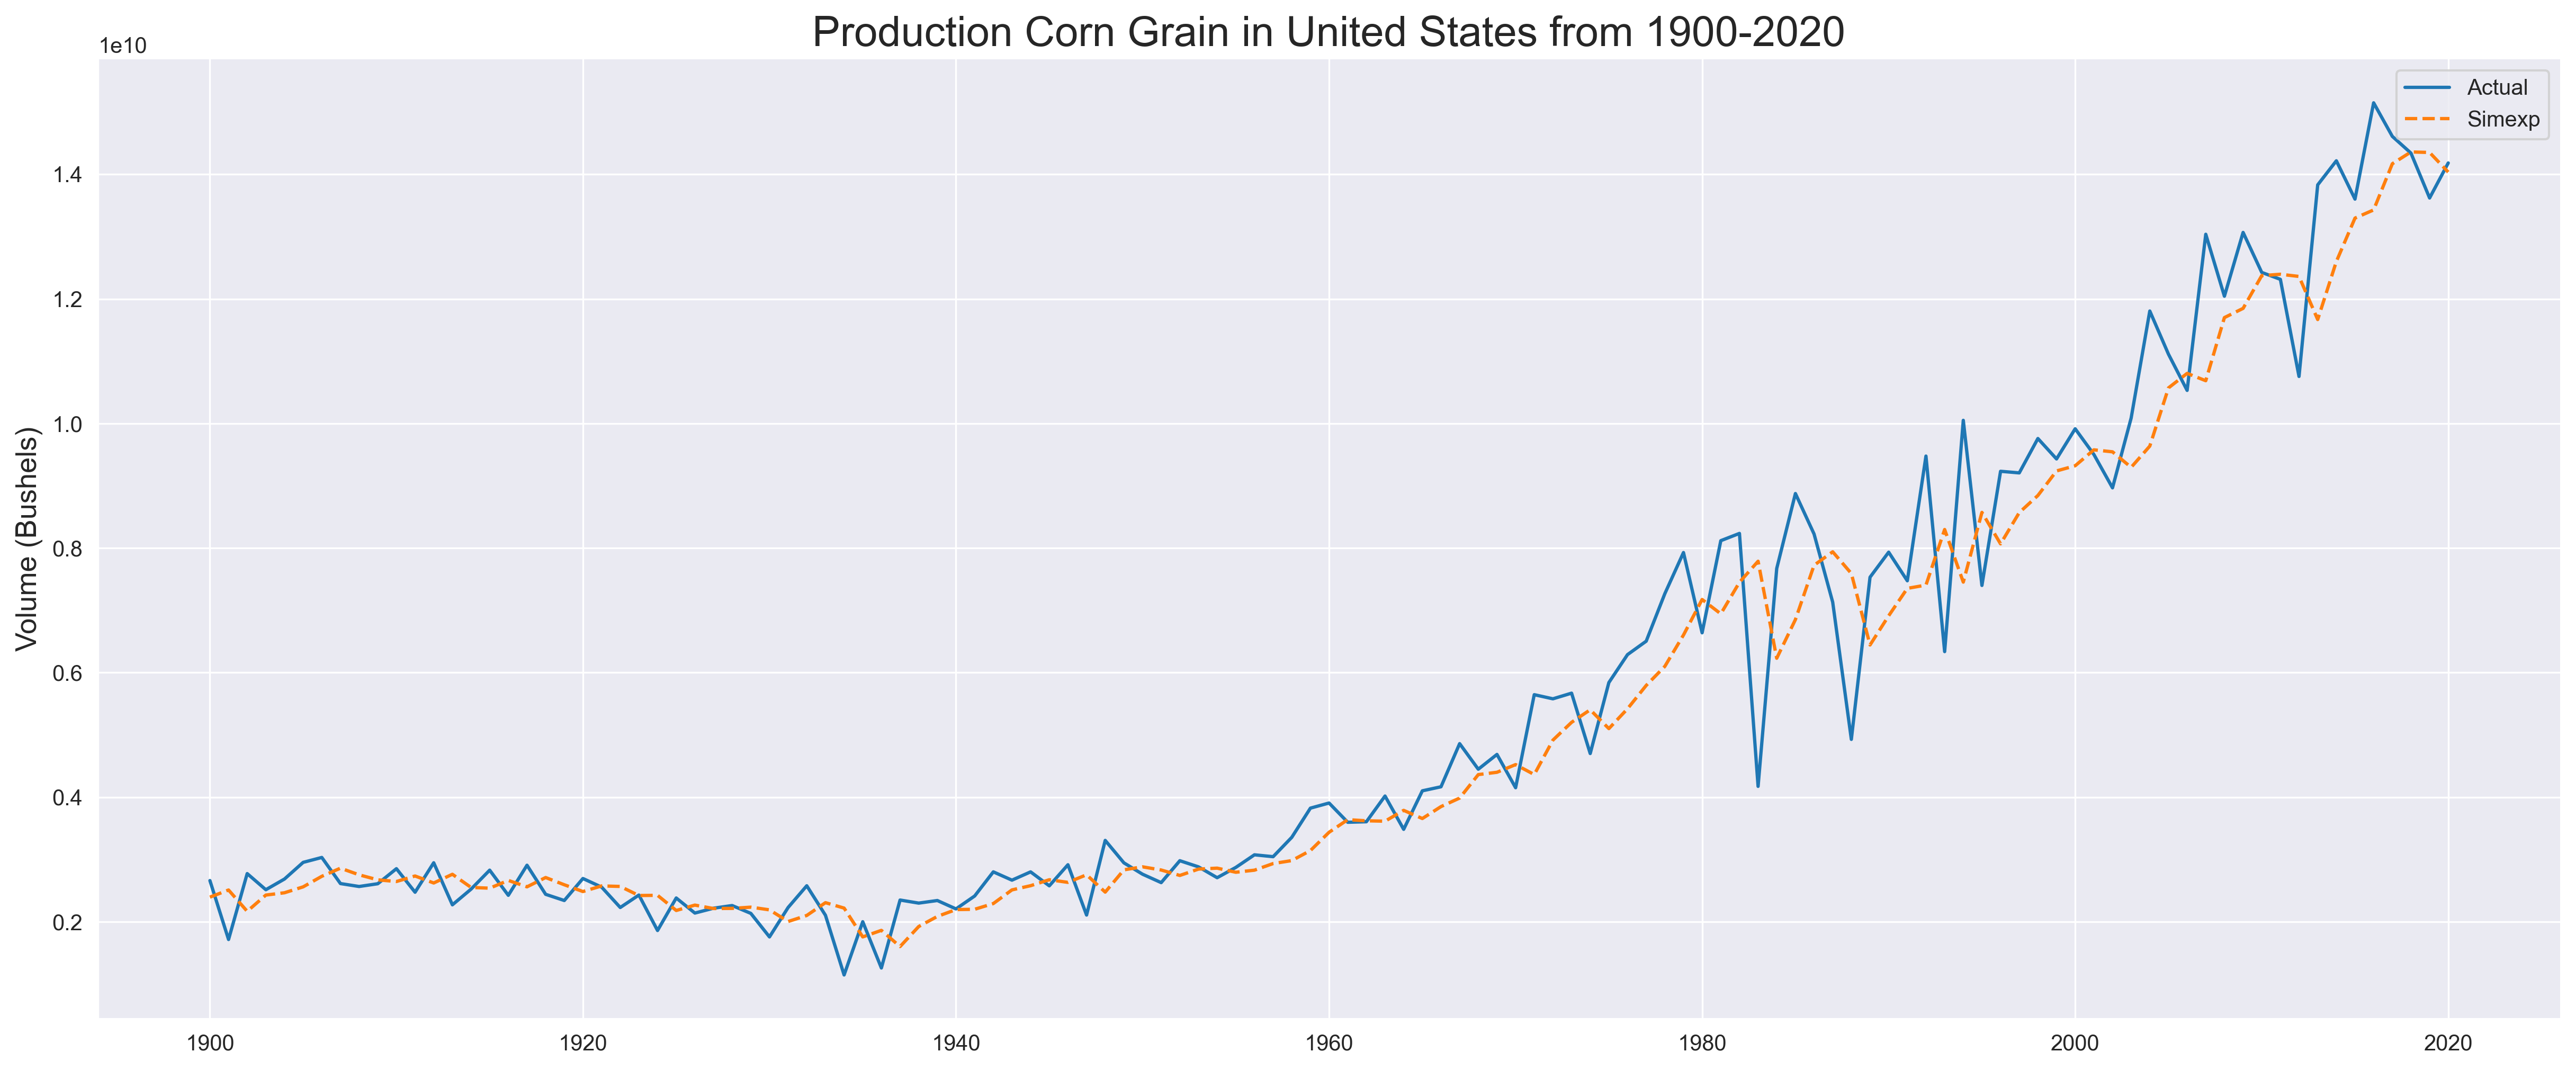

In [16]:
# Simple Exponential Smoothing modelling
sim = SimpleExpSmoothing(df['Value'], initialization_method="estimated").fit()

# Predicting the values
df['Simexp'] = sim.fittedvalues

# Plotting the data
fig, ax = plt.subplots(figsize = (20,8), dpi = 300)
plt.plot(df['Value'], label = 'Actual')
plt.plot(df['Simexp'], label = 'Simexp', linestyle = '--')

# Plot Settings
plt.legend()
plt.title('Production Corn Grain in United States from 1900-2020', fontsize = 19)
plt.ylabel('Volume (Bushels)', fontsize = 13)
sns.despine() 

In [17]:
# Printing the values for the alpha
print('Alpha : {a}'.format(a = sim.model.params['smoothing_level']))

Alpha : 0.4309302325581395


The result of the **Simple Exponential Smoothing** with parameters $\alpha \approx 0.43093$. follows the actual values well. We will compare this modelling with **Holt's Exponential Smoothing** to see whether an addition of variable improves the model. We will now plot the **Autocorrelation Function** of the redisuals.

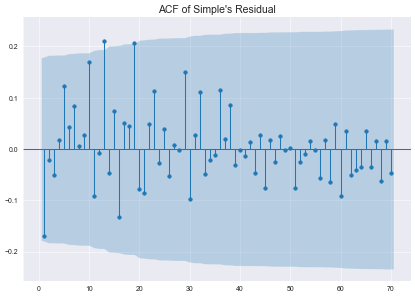

In [18]:
# Plotting the Residual of Holt Residual
fig, (ax1) = plt.subplots(1,1,figsize = (10,7), dpi = 50)
sgt.plot_acf(sim.resid, zero = False, lags = 70, ax = ax1)

# Plot settings
plt.title("ACF of Simple's Residual",size = 15)
sns.despine()
plt.show()

<br>We can also see from the **Autocorrelation Function** plot of the residuals that our errors might be autocorrelated to each other at the $13\text{th}$ lag. Next we will check the **Root Mean Squared Error** , **Mean Absolute Error Percentage**, **Akaike Information Criterion** (**AIC**) and **Bayesian Information Criterion** (**BIC**) metrics to compare the model. 

Both of **AIC** and **BIC** are metrics indicate the performance of our model with the main difference being **BIC** accounts the number of rows used to model the data while **AIC** does not. Luckily enough, the library `statsmodels` has pre-defined attributes to get **AIC** (`.aic`) and **BIC** (`.bic`). We can see that those metrics are lower than those of the smoothing methods. **Root Mean Squared Error** is a metric which simply calculates how far residuals are a measure of how far from the regression line data points are. To calculate this, we can use the function `mean_squared_error()` from `sklearn.metrics` and taking the square root of the value. Last but not the least, **Mean Absolute Error Percentage** is the average of the absolute errors in the model (which arguably tends to be less punishing).

In [19]:
# Calculating the RMSE
rmse_sim = (mean_squared_error(df['Value'],df['Simexp']))**0.5
print('RMSE  : {}'.format(rmse_sim))

# Calculating the MAPE
mape_sim = sum(abs(df['Value']-df['Simexp'])/df['Simexp']*100)/len(df)
print('MAPE  : {}'.format(mape_sim))

# Calculating AIC
aic_sim = sim.aic
print('AIC   : {}'.format(aic_sim))

# Calculating BIC
bic_sim = sim.bic
print('BIC   : {}'.format(bic_sim))

RMSE  : 888231226.4288312
MAPE  : 12.248536207353004
AIC   : 4990.347723038378
BIC   : 4995.939304129572


The **Root Mean Squared Error** for the Holt-Winter's exponential smoothing is $888,231,226$ which might seem a lot, but the target of the model itself is in the billions. Our **Mean Absolute Percentage Error** using the Holt-Winter's is roughly $12.25\%$. Our **AIC** score is $4,990.347$ and **BIC** is $4,995.939$. We will now check the distribution of the residuals as well as checking the stationarity of the residuals.

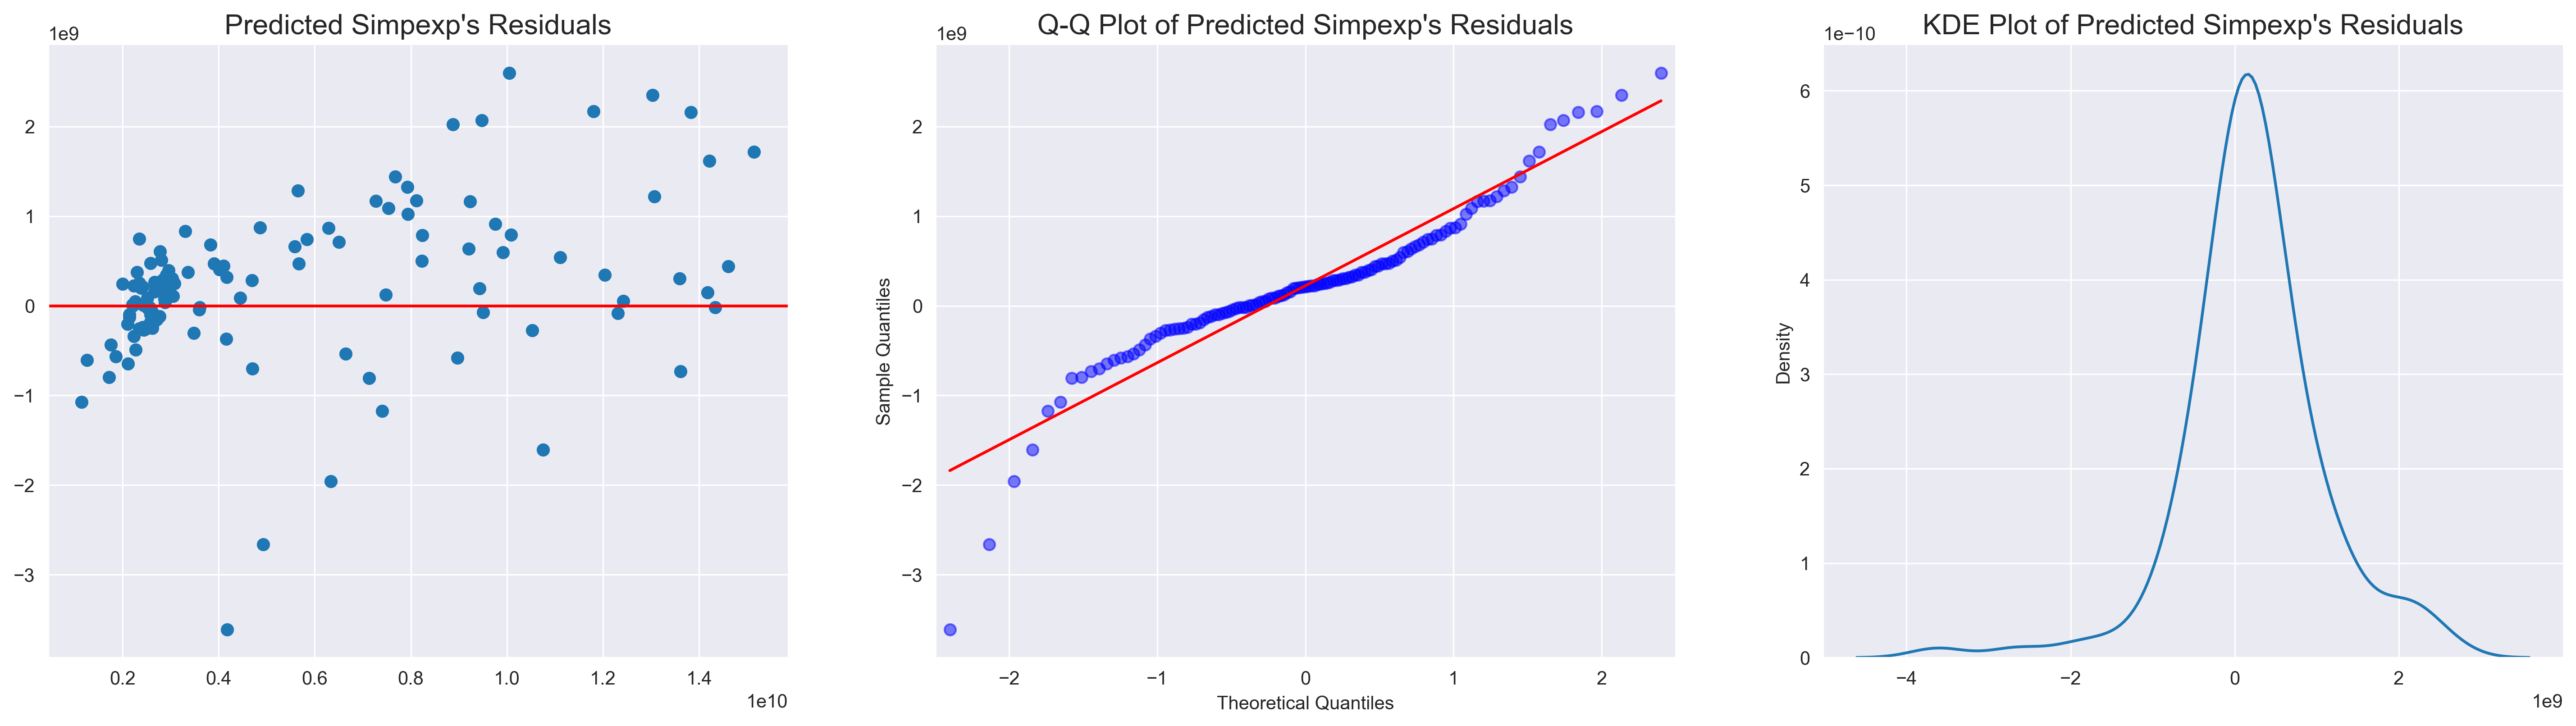

In [20]:
# Plotting the distribution of Holt Residuals
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (24,6), dpi = 300)
ax1.scatter(df['Value'], sim.resid)
sm.qqplot((sim.resid), line="s",ax=ax2,alpha=0.5)
sns.kdeplot((sim.resid), ax = ax3)

# Plot settings
ax1.set_title("Predicted Simpexp's Residuals",size = 15)
ax1.axhline(0, color = 'red')
ax2.set_title("Q-Q Plot of Predicted Simpexp's Residuals",fontsize = 15)
ax3.set_title("KDE Plot of Predicted Simpexp's Residuals", fontsize = 15)
sns.despine()

In [21]:
# Checking whether the error is white noise
print('The p-value of the Augmented Dickey-Fuller test is {}'.format(sts.adfuller(sim.resid)[1]))

The p-value of the Augmented Dickey-Fuller test is 4.621004558453458e-24


We can see from the plots above, we can see that our residuals of the **Simple Exponential Smoothing** almost resembles a normally distributed data, but it has a slight skew to the left. We can also see that relative to the actual values, the residuals does not follow a certain patern. Since the $\text{p-value}\approx 0$ using the **Augmented Dickey Fuller test**, it indicates that the residuals is indeed stationary.

### III.2. Holt's Exponential Smoothing (Double Exponential Smoothing)
**Holt's Exponential Smoothing** is a smoothing method is an exponential smoothing method which considers the presence of trend in the data (thus adding the parameter beta or $\beta$ into the mix). As mentioned, using **Holt's Exponential Smoothing** for data with trend is much better than using **Simple Exponential Smoothing**, thus we will try this smoothing method on our dataset and plot the result relative to the actual value.

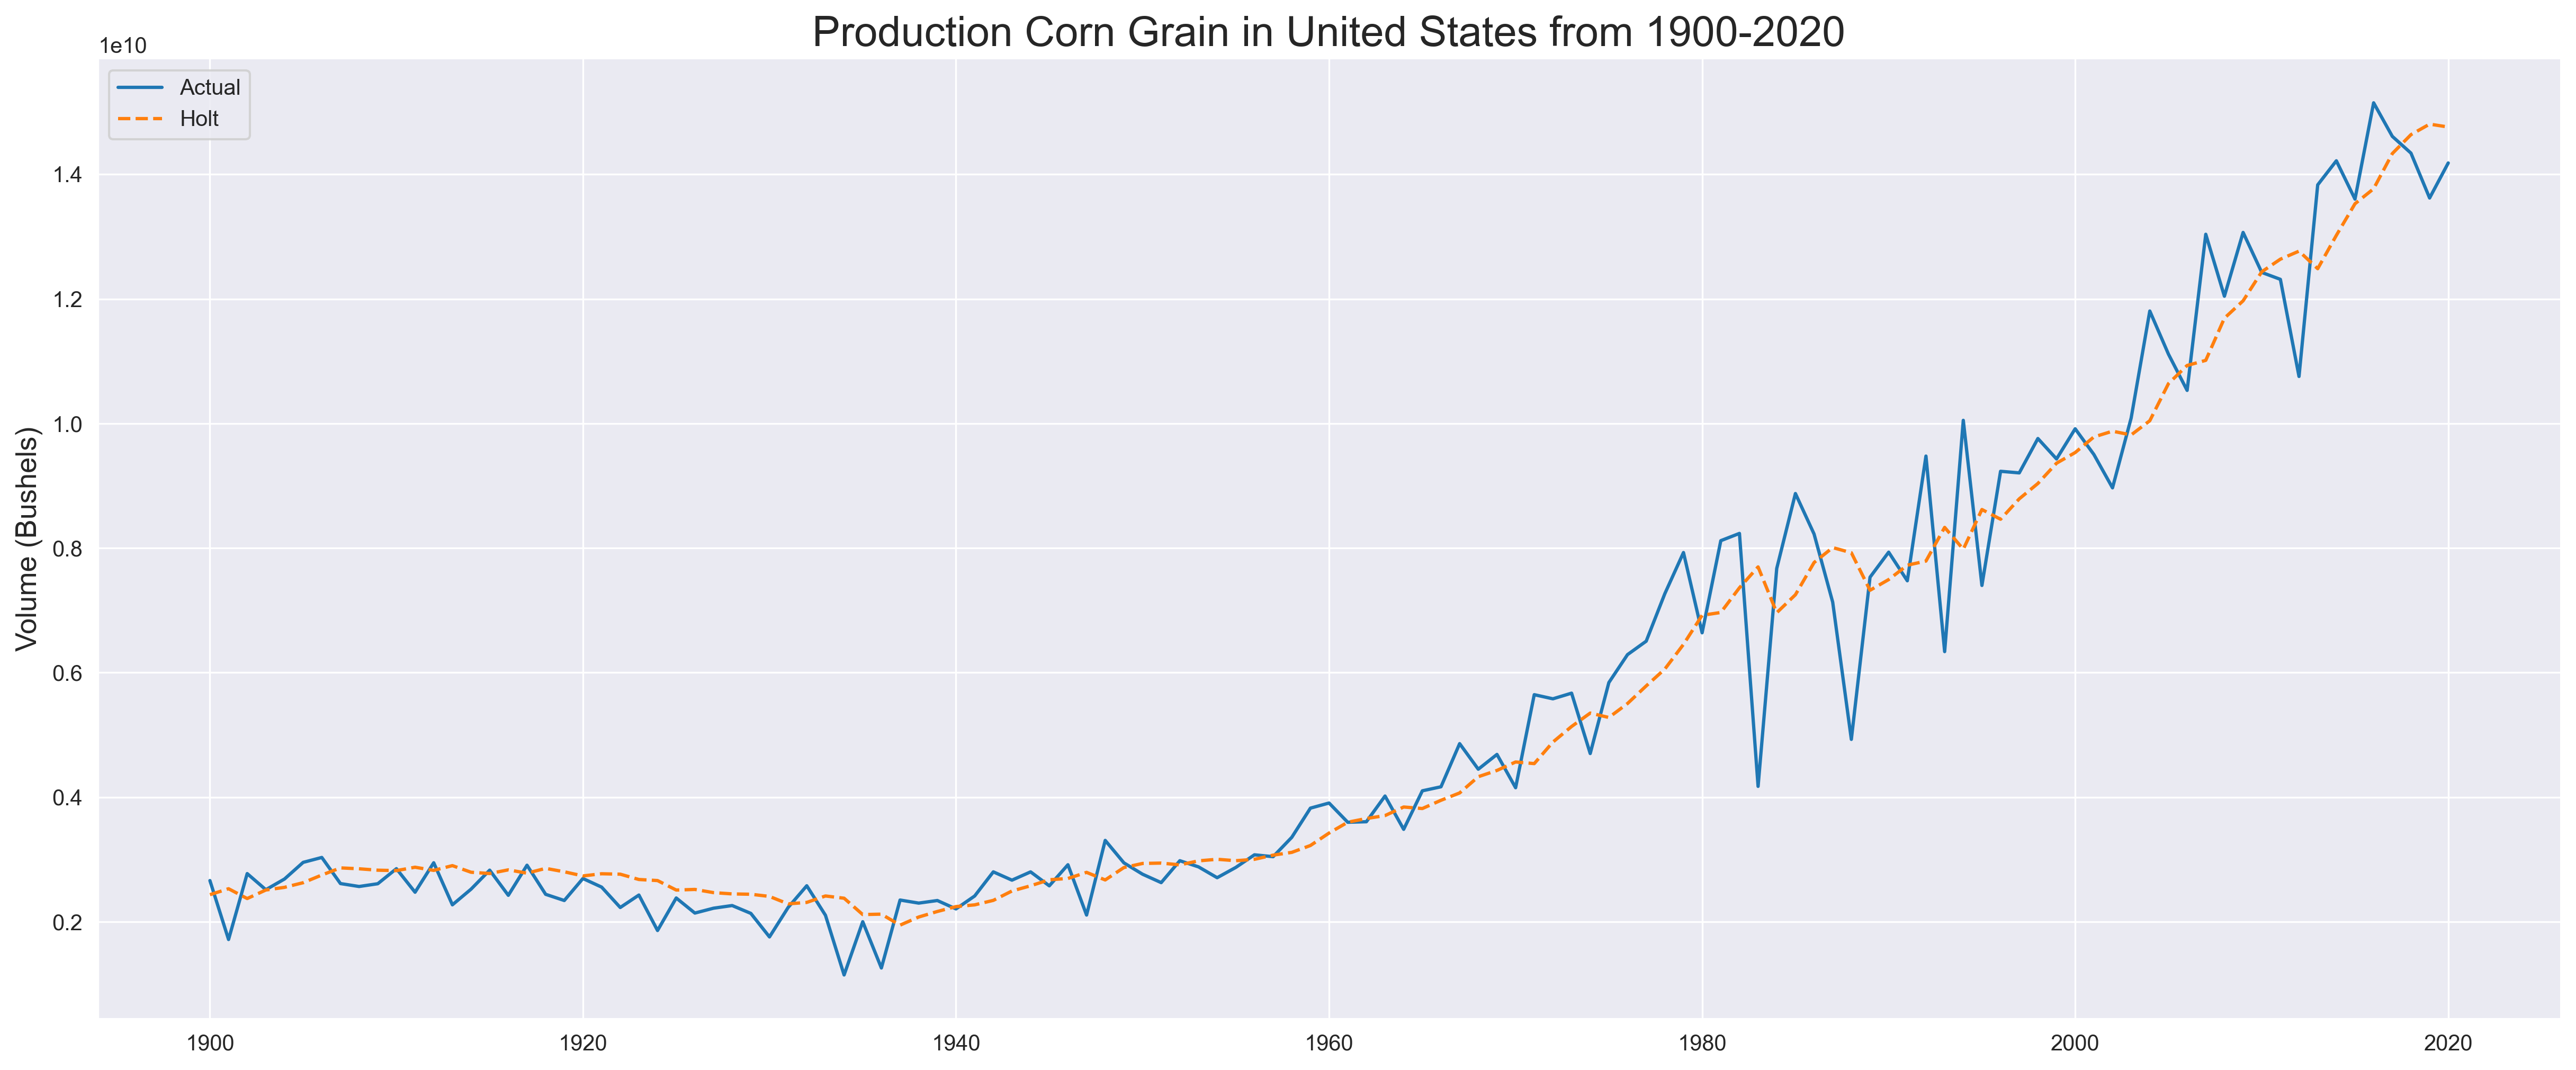

In [22]:
# Creating a double model
double = Holt(df['Value'], exponential = True, initialization_method = "estimated").fit()

# Predicting the values
df['Holt'] = double.fittedvalues

# Plotting the data
fig, ax = plt.subplots(figsize = (20,8), dpi = 300)
plt.plot(df['Value'], label = 'Actual')
plt.plot(df['Holt'], label = 'Holt', linestyle = '--')

# Plot Settings
plt.legend()
plt.title('Production Corn Grain in United States from 1900-2020', fontsize = 19)
plt.ylabel('Volume (Bushels)', fontsize = 13)
sns.despine() 

In [23]:
# Printing the values for the alpha and beta
print('Alpha : {a} \nBeta  : {b}'.format(a = double.model.params['smoothing_level'], 
                                         b = double.model.params['smoothing_trend']))

Alpha : 0.24071428571428571 
Beta  : 0.0001


We can see that the smoothing model with $\alpha \approx 0.2407$ and $\beta = 0.0001$ generally follows the actual corn production values quite well but as mentioned previously, it has a hard time following the rapid changes in our dataset. We will now check the **Autocorrelation Function** of the residuals.

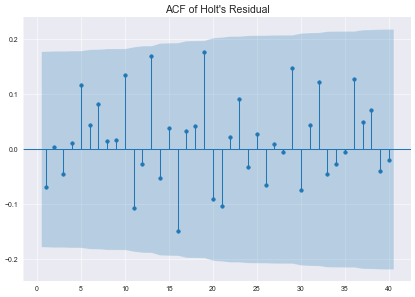

In [24]:
# Plotting the Residual of Holt Residual
fig, (ax1) = plt.subplots(1,1,figsize = (10,7), dpi = 50)
sgt.plot_acf(double.resid, zero = False, lags = 40, ax = ax1)

# Plot settings
plt.title("ACF of Holt's Residual",size = 15)
sns.despine()
plt.show()

We can also see from the **Autocorrelation Function** plot of the residuals that our errors are not autocorrelated to each other at any lags. Next we will check the **Root Mean Squared Error** , **Mean Absolute Error Percentage**, **Akaike Information Criterion** and **Bayesian Information Criterion** metrics to compare the model.

In [25]:
# Calculating the RMSE
rmse_double = (mean_squared_error(df['Value'],df['Holt']))**0.5
print('RMSE  : {}'.format(rmse_double))

# Calculating the MAPE
mape_double = sum(abs(df['Value']-df['Holt'])/df['Value']*100)/len(df)
print('MAPE  : {}'.format(mape_double))

# Calculating AIC
aic_double = double.aic
print('AIC   : {}'.format(aic_double))
 
# Calculating BIC
bic_double = double.bic
print('BIC   : {}'.format(bic_double))

RMSE  : 818114044.7813385
MAPE  : 12.518547070058409
AIC   : 4974.447977543117
BIC   : 4985.631139725504


The **Root Mean Squared Error** for the **Holt's Exponential Smoothing** is $818,114,044.78$ which might seem a lot, but the target of the model itself is in the billions. Our **Mean Absolute Percentage Error** using the Holt's is roughly $12.52\%$. The **AIC** score for this model is $4,974.448$ and **BIC** is $4,985.631$. We can see that there is indeed a decrease in **Root Mean Squared Error** with a slight increase in **Mean Absolute Percentage Error**. Both **AIC** and **BIC** increases, thus it might indicate that the **Simple Exponential Smoothing** might need to be considered further.

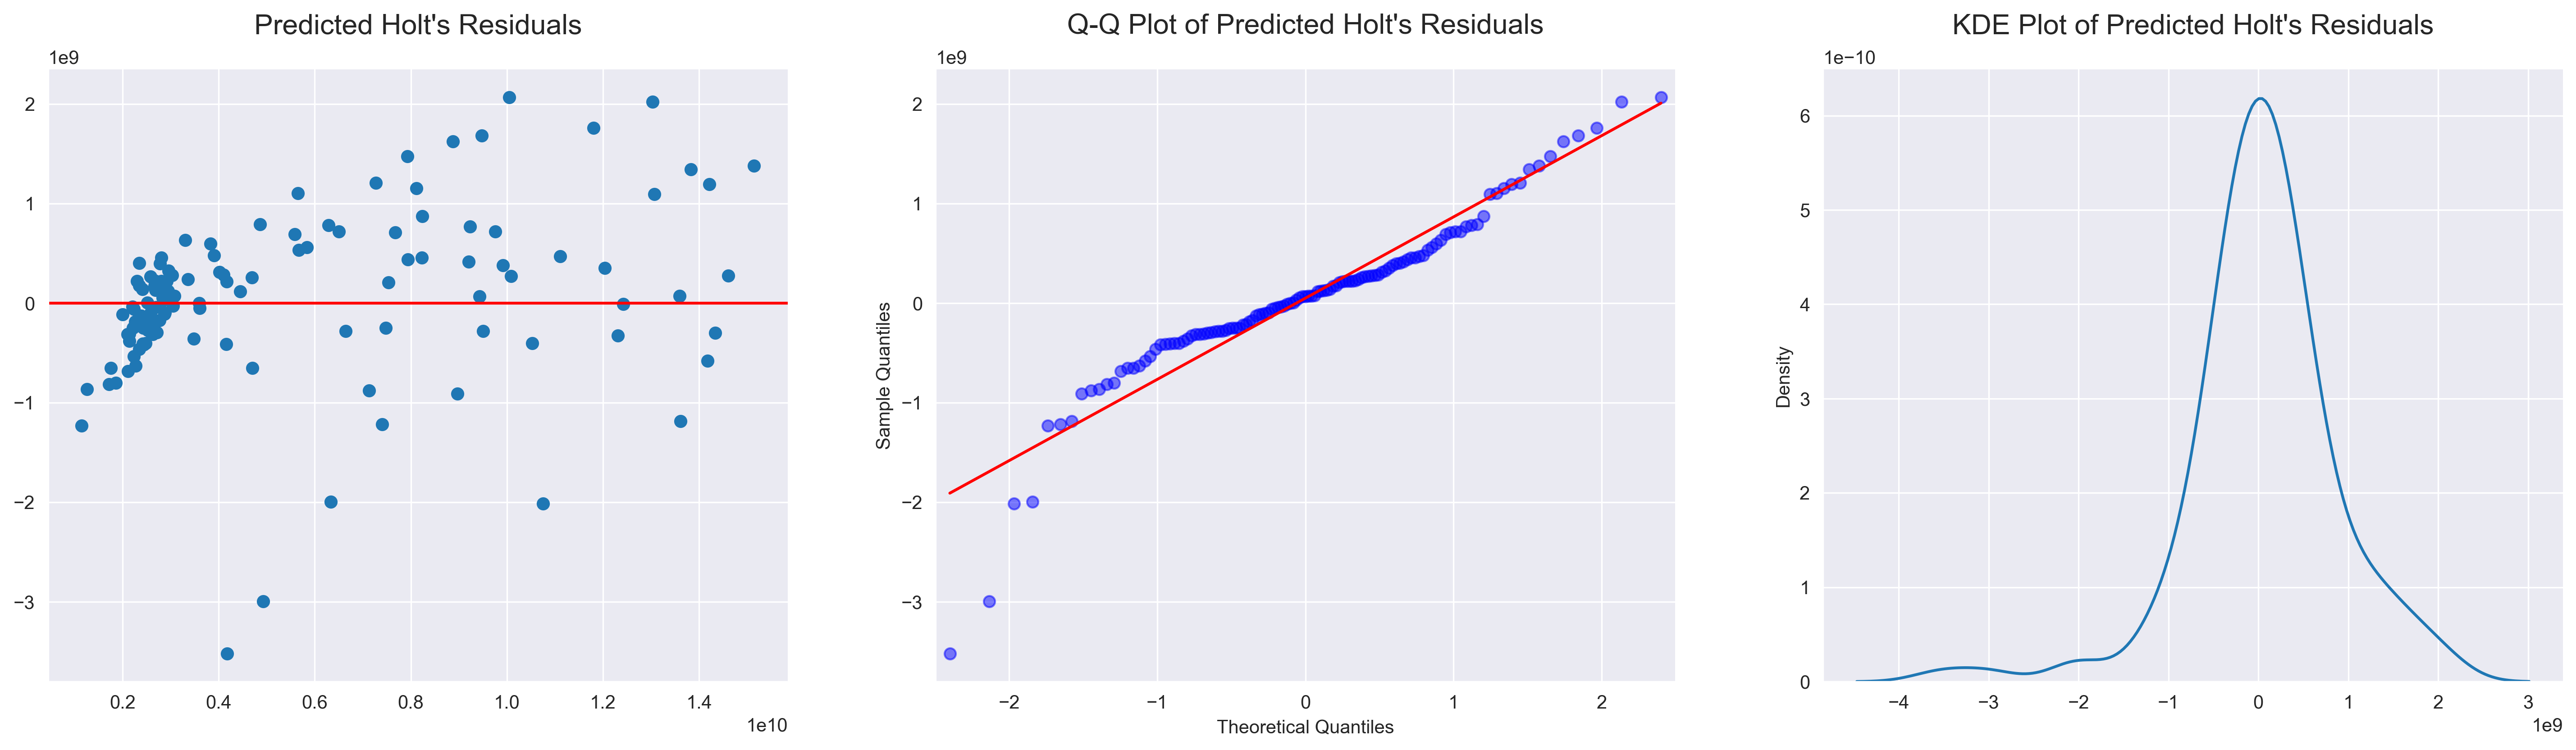

In [26]:
# Plotting the distribution of Holt Residuals
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (24,6), dpi = 300)
ax1.scatter(df['Value'], double.resid)
sm.qqplot((double.resid), line="s",ax=ax2,alpha=0.5)
sns.kdeplot((double.resid), ax = ax3)

# Plot settings
ax1.set_title("Predicted Holt's Residuals",size = 15, y = 1.04)
ax1.axhline(0, color = 'red')
ax2.set_title("Q-Q Plot of Predicted Holt's Residuals",fontsize=15,y=1.04)
ax3.set_title("KDE Plot of Predicted Holt's Residuals", fontsize=15,y=1.04)
sns.despine()

In [27]:
# Checking whether the error is white noise
print('The p-value of the Augmented Dickey-Fuller test is {}'.format(sts.adfuller(double.resid)[1]))

The p-value of the Augmented Dickey-Fuller test is 2.3966759793800532e-21


We can see from the plots above, we can see that our residuals of the **Holt's Exponential Smoothing** almost resembles a normally distributed data, but it has a slight skew to the left. We can also see that relative to the actual values, the residuals does not follow a certain patern. The **Augmented Dickey Fuller test** indicates that the residuals is indeed stationary (based on the $\text{p-value}\approx 0$).

Thus we arrived at the conclusion that we will choose **Holt's Exponential Smoothing** compared to **Simple Exponential Smoothing**. This decision is based on the lower **RMSE** and **MAPE** score with the compromise of **AIC** and **BIC** score.

## IV. Modelling

### IV.1. Autocorrelation Function and Partial Autocorrelation Function
We will start this section by plotting the **Correlogram** (Autocorrelation Function) and the **Partial Autocorrelation Function** plot to give some ideas of how our data correlates with different lags, especially our differenced we have checked that our data is not stationary unless we perform first order differencing. This process also helps us in determining the parameter for our model manually.

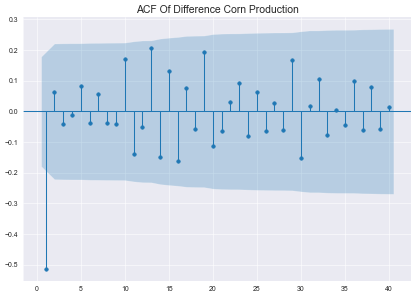

In [28]:
# Plotting the ACF of corn production
fig, (ax1) = plt.subplots(1,1,figsize = (10,7), dpi = 50)
sgt.plot_acf(df.Diff.dropna(), zero = False,ax = ax1, lags = 40)

# Plot settings
plt.title("ACF Of Difference Corn Production",size = 15)
sns.despine()
plt.show()

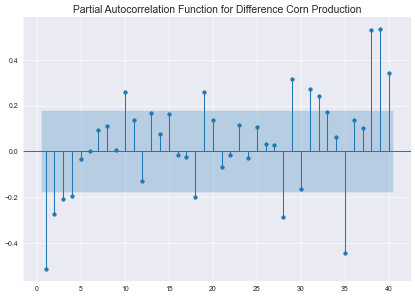

In [29]:
# Plotting the PACF of corn production
fig, (ax1) = plt.subplots(1,1,figsize = (10,7), dpi = 50)
sgt.plot_pacf(df.Diff.dropna(), lags = 40, alpha = 0.05, zero = False , method = ('ols'), ax = ax1)

# Plot settings
plt.title("Partial Autocorrelation Function for Difference Corn Production",size = 15)
sns.despine()
plt.show()

From both plots we can observe the behaviour of the dataset. After the first lag, the **Correlelogram** cuts off and slowly decays, while the **Partial Autocorrelation Function** plot does not cuts off immediately, rather slowly moving back and forth the 0 threshold. Thus we will be checking for an ARIMA model with a base model of **ARMA(1,1)**.

### IV.2. Log-Likelihood Ratio Test
The Log-Likelihood Ratio Test (LLR) is a test one can use to compare the performance of the model (specifically whether there is a significant difference for two different models). The **LLR test** follows the $\chi^2$ distribution and one of the ways we can test it is by measuring the $\text{p-value}$. The hypothesis for the **LLR test**  is as follow:

<br>$H_0 : \text{There is no difference in performance between the simple model and the complex model}$
$H_a : \text{There is difference in performance between the simple model and the complex model}$

<br>**Decision Rules**

$H_0 \space \text{is rejected if} P\text{-value} \leq \alpha = 0.05$

<br>We will now define our testing function which will help us down the road.

In [30]:
# Defining the LLR function 
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

### IV.3. ARMA Modelling

#### IV.3.A. ARMA(1,1)
As mentioned in section **IV.I.**, we will use the ARMA to model our data. Simply short, ARMA model is the combination of Autoregression and Moving Average Regression. The parameter for the ARMA model itself which is $\text{(p, q)}$ where $p$ is the autoregression order,  and $q$ is the moving average regression order. ARMA can be written mathematically as:

$y_t = \phi_{t-1}y_{t-1} + ... + \phi_{t-p}y_{t-p} + \epsilon_t - \theta_1 \epsilon_{t-1} - ... - \theta_q \epsilon_{t-q}$

**Where**:
 - $p$		= The lag for autoregression
 - $q$		= The lag for moving average
 - $y_{t-p}$ = The observed value at given lag (p)
 - $\epsilon_{t-q}$   	= The residual value at given lag (q)
 - $\phi_p$		= The parameter for the autoregression at given lag (p) 
 - $\theta_q$ 		= The parameter for the moving average at given lag (q)

We will be doing ARMA modelling to the differenced data in the column `Diff` and dropping the first value since it is NaN. To do this in ARMA modelling in Python, we will need the help of the function `ARMA()` which is available from the library `from statsmodels.tsa.arima_model`. First we will be modelling our an **ARMA $(1,1)$** as a baseline model to be compared to after we change the parameters.

In [31]:
# Modelling ARMA(1,1)
arma_base = ARMA(df.Diff.dropna(), order=(1,1))

# Fitting the model
result_arma_base= arma_base.fit()

# Previewing the summary
result_arma_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Diff   No. Observations:                  120
Model:                     ARMA(1, 1)   Log Likelihood               -2637.742
Method:                       css-mle   S.D. of innovations      849067814.479
Date:                Wed, 07 Jul 2021   AIC                           5283.484
Time:                        12:03:28   BIC                           5294.634
Sample:                    01-01-1901   HQIC                          5288.012
                         - 01-01-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         9.6e+07   2.79e+07      3.447      0.001    4.14e+07    1.51e+08
ar.L1.Diff    -0.1450      0.118     -1.233      0.218      -0.376       0.086
ma.L1.Diff    -0.5947      0.085     -7.037      0.000      -0.760      -0.429
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.8977           +0.0000j            6.8977            0.5000
MA.1            1.6814           +0.0000j            1.6814            0.0000
-----------------------------------------------------------------------------
"""

From the model, we arrived at the equation:
<br>$\hat{z}_t = -0.145y_{t-1} + \epsilon_t -0.5947 \epsilon_{t-1} + 9.6*10^7$

We can see the result of our **ARMA $(1,1)$**, our **Akaike Information Criterion** or **AIC** score is $5,283.484$ and our **Bayesian Information Criterion** or **BIC** score is $5,294.634$. We can also observe that the first autoregression lag might not be significant with respect to the population.

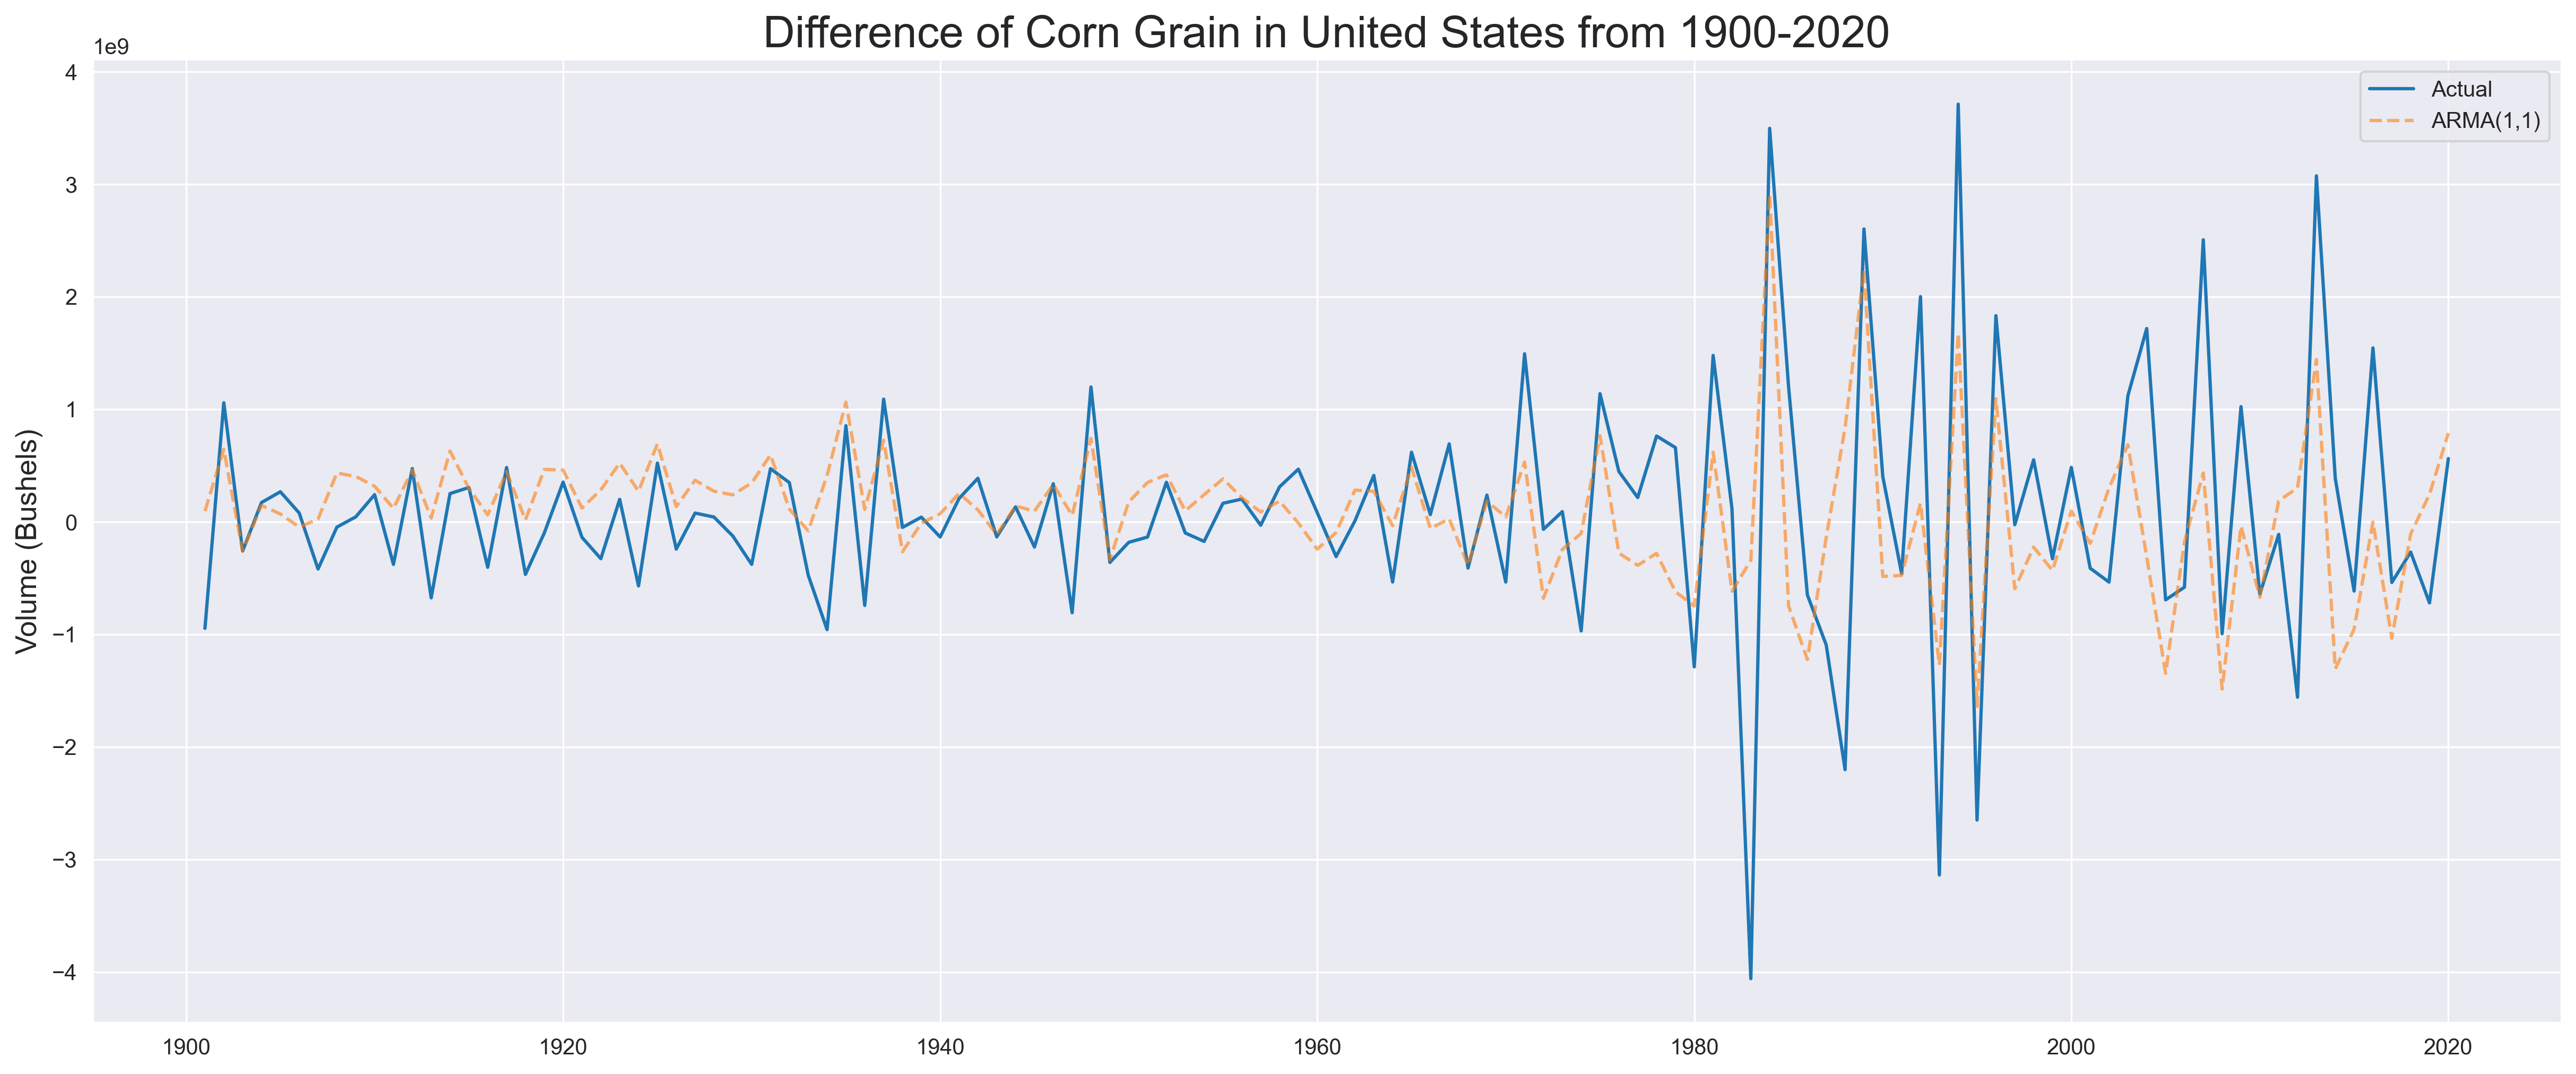

In [32]:
# Plotting the data
fig, ax = plt.subplots(figsize = (20,8), dpi = 300)
plt.plot(df.Diff, label = 'Actual')
plt.plot(result_arma_base.fittedvalues, alpha = 0.6, label = 'ARMA(1,1)', linestyle = '--')

# Plot Settings
plt.legend()
plt.title('Difference of Corn Grain in United States from 1900-2020', fontsize = 20)
plt.ylabel('Volume (Bushels)', fontsize = 13)
sns.despine() 

The plot above indicates the capability of the model in capturing the differenced data with respect of time. The **ARMA $(1,1)$** have decent capability of following the differenced data. We will now use the differenced model's fitted values and use the a formula and compare it to the pre-differenced data. The formula is:

$\hat{y}_{t+1}=y_t+\hat{z}_{t+1}$

**Where**:
- $\hat{y}_{t+1}$ : The predicted value at time $t+1$
- $y_t$ : The actual value at time $t$
- $\hat{z}_{t+1}$ : The predicted differneced value at $t+1$`

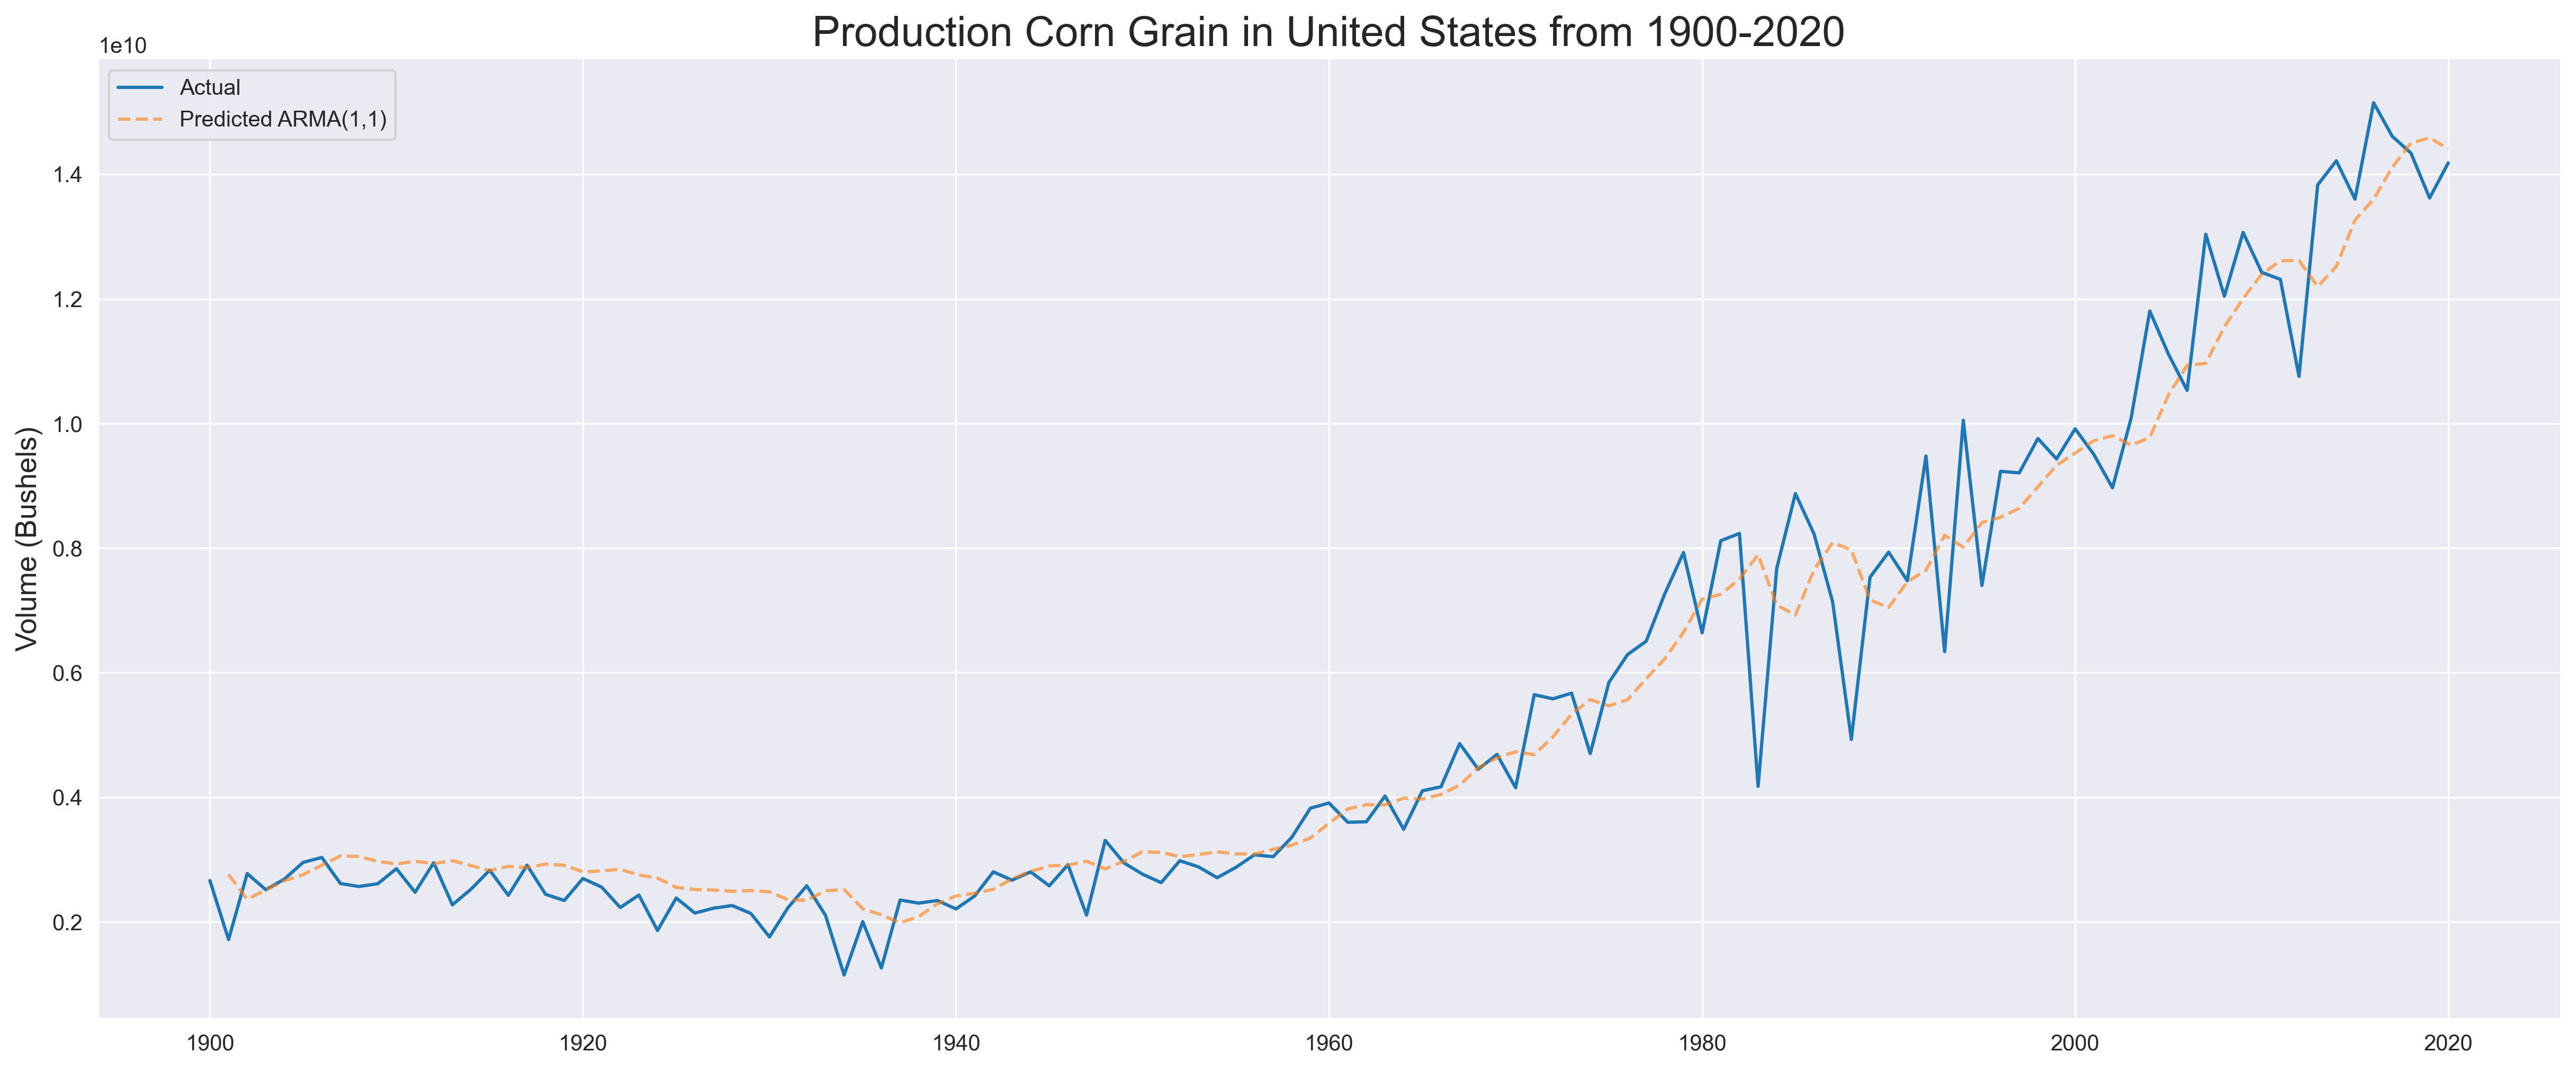

In [33]:
# Appending the predicted value to the dataframe
df['pred_arma_base'] = result_arma_base.fittedvalues + df.Value.shift(1)

# Plotting the data
fig, ax = plt.subplots(figsize = (20,8), dpi = 300)
plt.plot(df['Value'], label = 'Actual')
plt.plot(df['pred_arma_base'], alpha = 0.6, label = 'Predicted ARMA(1,1)', linestyle = '--')

# Plot Settings
plt.legend()
plt.title('Production Corn Grain in United States from 1900-2020', fontsize = 19)
plt.ylabel('Volume (Bushels)', fontsize = 13)
sns.despine() 

We see that our base model captured the corn production value pretty well considering we have not really tweaked the model at all. We will now plot the residuals of the model to see whether the model follows the assumption that the errors should not be autocorrelated. 

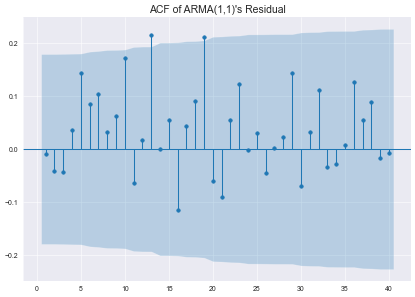

In [34]:
# Plotting the ACF of ARMA(1,1) Residual
fig, (ax1) = plt.subplots(1,1,figsize = (10,7), dpi = 50)
sgt.plot_acf(result_arma_base.resid, zero = False, lags = 40, ax = ax1)

# Plot settings
plt.title("ACF of ARMA(1,1)'s Residual", size = 15)
sns.despine()
plt.show()

We can also see from the **Autocorrelation Function** plot of the residuals that our errors are autocorrelated to each other with at the $13\text{th}$ and $19\text{th}$ lag. Next we will check the **Root Mean Squared Error** , **Mean Absolute Error Percentage**, **Akaike Information Criterion** and **Bayesian Information Criterion** metrics to compare the model.

In [35]:
# Calculating the MSE and RMSE
rmse_arma_base = (mean_squared_error(df['Value'].diff(periods = 1).dropna(), result_arma_base.fittedvalues))**0.5

# Printing the result
print('RMSE  : {}'.format(rmse_arma_base))

# Calculating the MAPE
mape_arma = np.mean(abs((df.Value[1:] - df.pred_arma_base[1:]))*100/df.Value[1:])
print('MAPE  : {}'.format(mape_arma))

# Calculating AIC
aic_arma_base = result_arma_base.aic
print('AIC   : {}'.format(aic_arma_base))
 
# Calculating BIC
bic_arma_base = result_arma_base.bic
print('BIC   : {}'.format(bic_arma_base))

RMSE  : 851072982.6220566
MAPE  : 13.259186913877226
AIC   : 5283.484318599457
BIC   : 5294.634285570585


The **Root Mean Squared Error** for the **ARMA $(1,1)$** is $851,072,982.62$ which might seem a lot, but the target of the model itself is in the billions. Our **Mean Absolute Percentage Error** using the Holt's is roughly $13.26\%$. The **AIC** score for this model is $5,283.484$ and **BIC** is $5,294.634$. We will now plot the distribution of **ARMA $(1,1)$** residuals and check its stationarity using the **Augmented Dickey-Fuller test**.

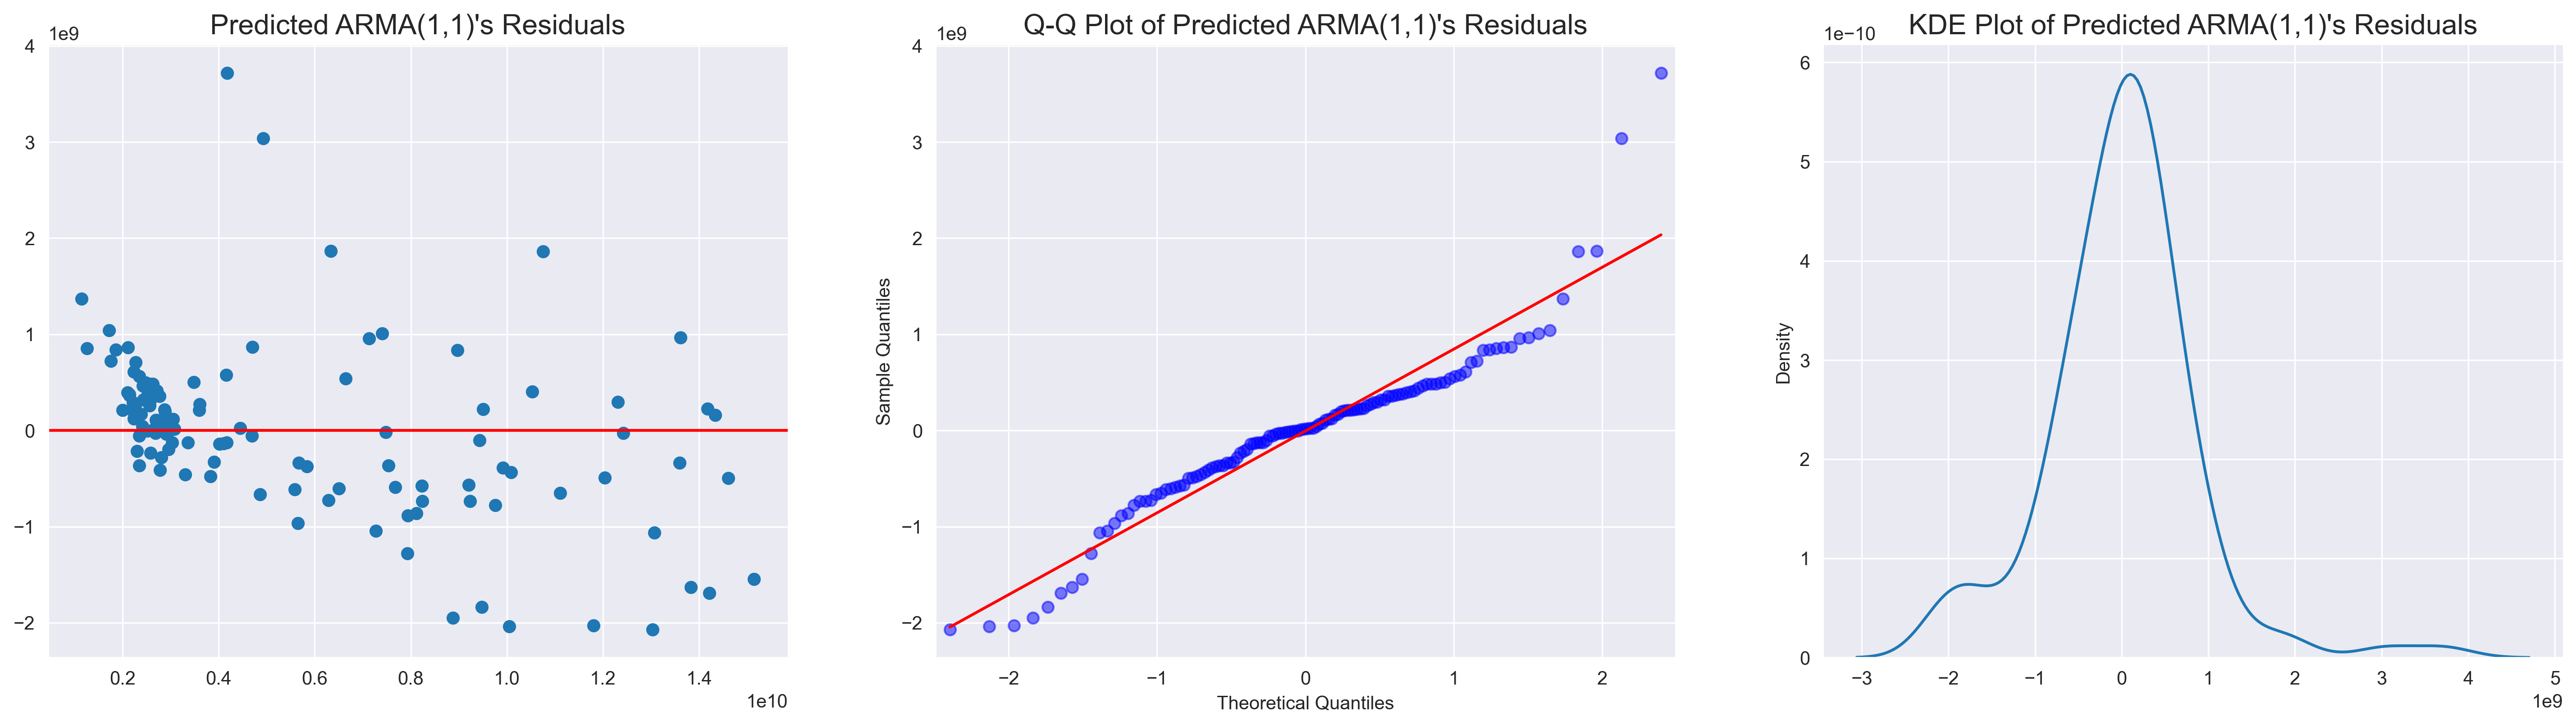

In [36]:
# Plotting the distribution of ARMA(1,1) Residuals
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (24,6), dpi = 300)
ax1.scatter(df['Value'][1:],(df['pred_arma_base'] - df['Value'])[1:])
sm.qqplot((df['pred_arma_base'] - df['Value'])[1:], line="s",ax=ax2,alpha=0.5)
sns.kdeplot((df['pred_arma_base'] - df['Value'])[1:], ax = ax3)

# Plot settings
ax1.set_title("Predicted ARMA(1,1)'s Residuals",size = 15)
ax1.axhline(0, color = 'red')
ax2.set_title("Q-Q Plot of Predicted ARMA(1,1)'s Residuals",fontsize=15)
ax3.set_title("KDE Plot of Predicted ARMA(1,1)'s Residuals", fontsize=15)
sns.despine()

In [37]:
# Checking whether the error is white noise
print('The p-value of the Augmented Dickey-Fuller test is {}'.format(sts.adfuller(result_arma_base.resid[1:])[1]))

The p-value of the Augmented Dickey-Fuller test is 1.8241853978201626e-19


We can see from the plots above, we can see that our residuals of the **ARMA $(1,1)$** almost resembles a normally distributed data, but it has a slight skew to the right and fat-tail on both ends. We can also see that relative to the actual values, the residuals does not follow a certain patern. The **Augmented Dickey Fuller test** indicates that the residuals is indeed stationary (based on the $\text{p-value}\approx 0$).

#### IV.3.B. Defining a Function to Find the Best Parameter
We will now define a function which performs the laborous parameter searching for us. This function iterates through all the possible combinations within a certain pre-defined range by us. After that, it will get the combination with recursively check the **LLR test** to see whether more complex models perform better than the simple model. 

In [38]:
# Defining a function to get the best parameter
def best_par(dat = df,p = 1,q = 1):
    # Defining some empty list
    LL = list()
    p_i_q = list()
    deg_f = list()

    # Looping through every p,i,q combination
    for b in range (p+1):
        for c in range (q+1):
            try:
                model = ARMA(dat, order=(b,c))
                results = model.fit()
                LL.append(results.llf)
                p_i_q.append((b, c))
                deg_f.append(b + c)
            except: 
                pass
                
    # Defining some initial values
    best_ll = LL[0]
    best_df = deg_f[0]
    best_combo = p_i_q[0]

    # Brutally testing the LLR
    for temp in range(1,len(LL)):
        LR = (2*(LL[temp] - best_ll))
        DF = abs(deg_f[temp] - best_df)
        if DF == 0: DF = 1
        pval = chi2.sf(LR, DF)
        #print('nilai p-val {a}, model1 {b}, model2{c}'.format(a = pval, b = best_combo, c = p_i_q[temp]))
        if pval <= 0.05:
            best_ll = LL[temp]
            best_df = deg_f[temp]
            best_combo = p_i_q[temp]
        
    # Returning the result
    return {'combo':best_combo,'LL':best_ll}

#### IV.3.C. ARMA using the Best Parameter
We will now use the function above to get the best parameters. We set our limit at $p,q = 10$ and just as the previous model, we will be modelling the differenced dataset instead of the actual corn production values. Running this function might take a little while due to the simplistic approach and depending on the system's capability.

In [39]:
# # Using the function to get the best parameter combination
# best_combination = best_par(dat = df.Diff.dropna(), p = 10,  q = 10)

# # Previewing the result
# best_combination

We can see from the result that the best model given our limit is **ARMA $(p = 1, q = 2)$** with the **Log-Likelihood** of $-2,633.83$. We will now use this information to create the model.

In [40]:
# Modelling ARMA with the best parameter
arma_best = ARMA(df.Diff.dropna(), order = (1,2))

# Fitting the model to the data
result_arma_best = arma_best.fit()

# Previewing the model summary
result_arma_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Diff   No. Observations:                  120
Model:                     ARMA(1, 2)   Log Likelihood               -2633.830
Method:                       css-mle   S.D. of innovations      819455053.572
Date:                Wed, 07 Jul 2021   AIC                           5277.659
Time:                        12:03:32   BIC                           5291.597
Sample:                    01-01-1901   HQIC                          5283.319
                         - 01-01-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         9.6e+07   4.67e+07      2.056      0.040    4.49e+06    1.88e+08
ar.L1.Diff     0.8943      0.075     11.877      0.000       0.747       1.042
ma.L1.Diff    -1.7100      0.075    -22.650      0.000      -1.858      -1.562
ma.L2.Diff     0.7790      0.064     12.143      0.000       0.653       0.905
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1182           +0.0000j            1.1182            0.0000
MA.1            1.0975           -0.2812j            1.1330           -0.0399
MA.2            1.0975           +0.2812j            1.1330            0.0399
-----------------------------------------------------------------------------
"""

From the model, we arrived at the equation:
<br>$\hat{z}_t = 0.8943y_{t-1} + \epsilon_t -1.71 \epsilon_{t-1} - 0.779 \epsilon_{t-2} + 9.6*10^7$

We can see the result of our **ARMA $(1,2)$**, our **Akaike Information Criterion** or **AIC** score is $5,277.659$ and our **Bayesian Information Criterion** or **BIC** score is $5,291.597$. We can observe that all lags both autoregression and moving average regression are significant. We will now plot the result of **ARMA $(1,2)$** and compare it to the differenced values.

$\hat{y}_t = y_{t-1}+0.8943y_{t-1} + \epsilon_t -1.71 \epsilon_{t-1} - 0.779 \epsilon_{t-2} + 9.6*10^7$

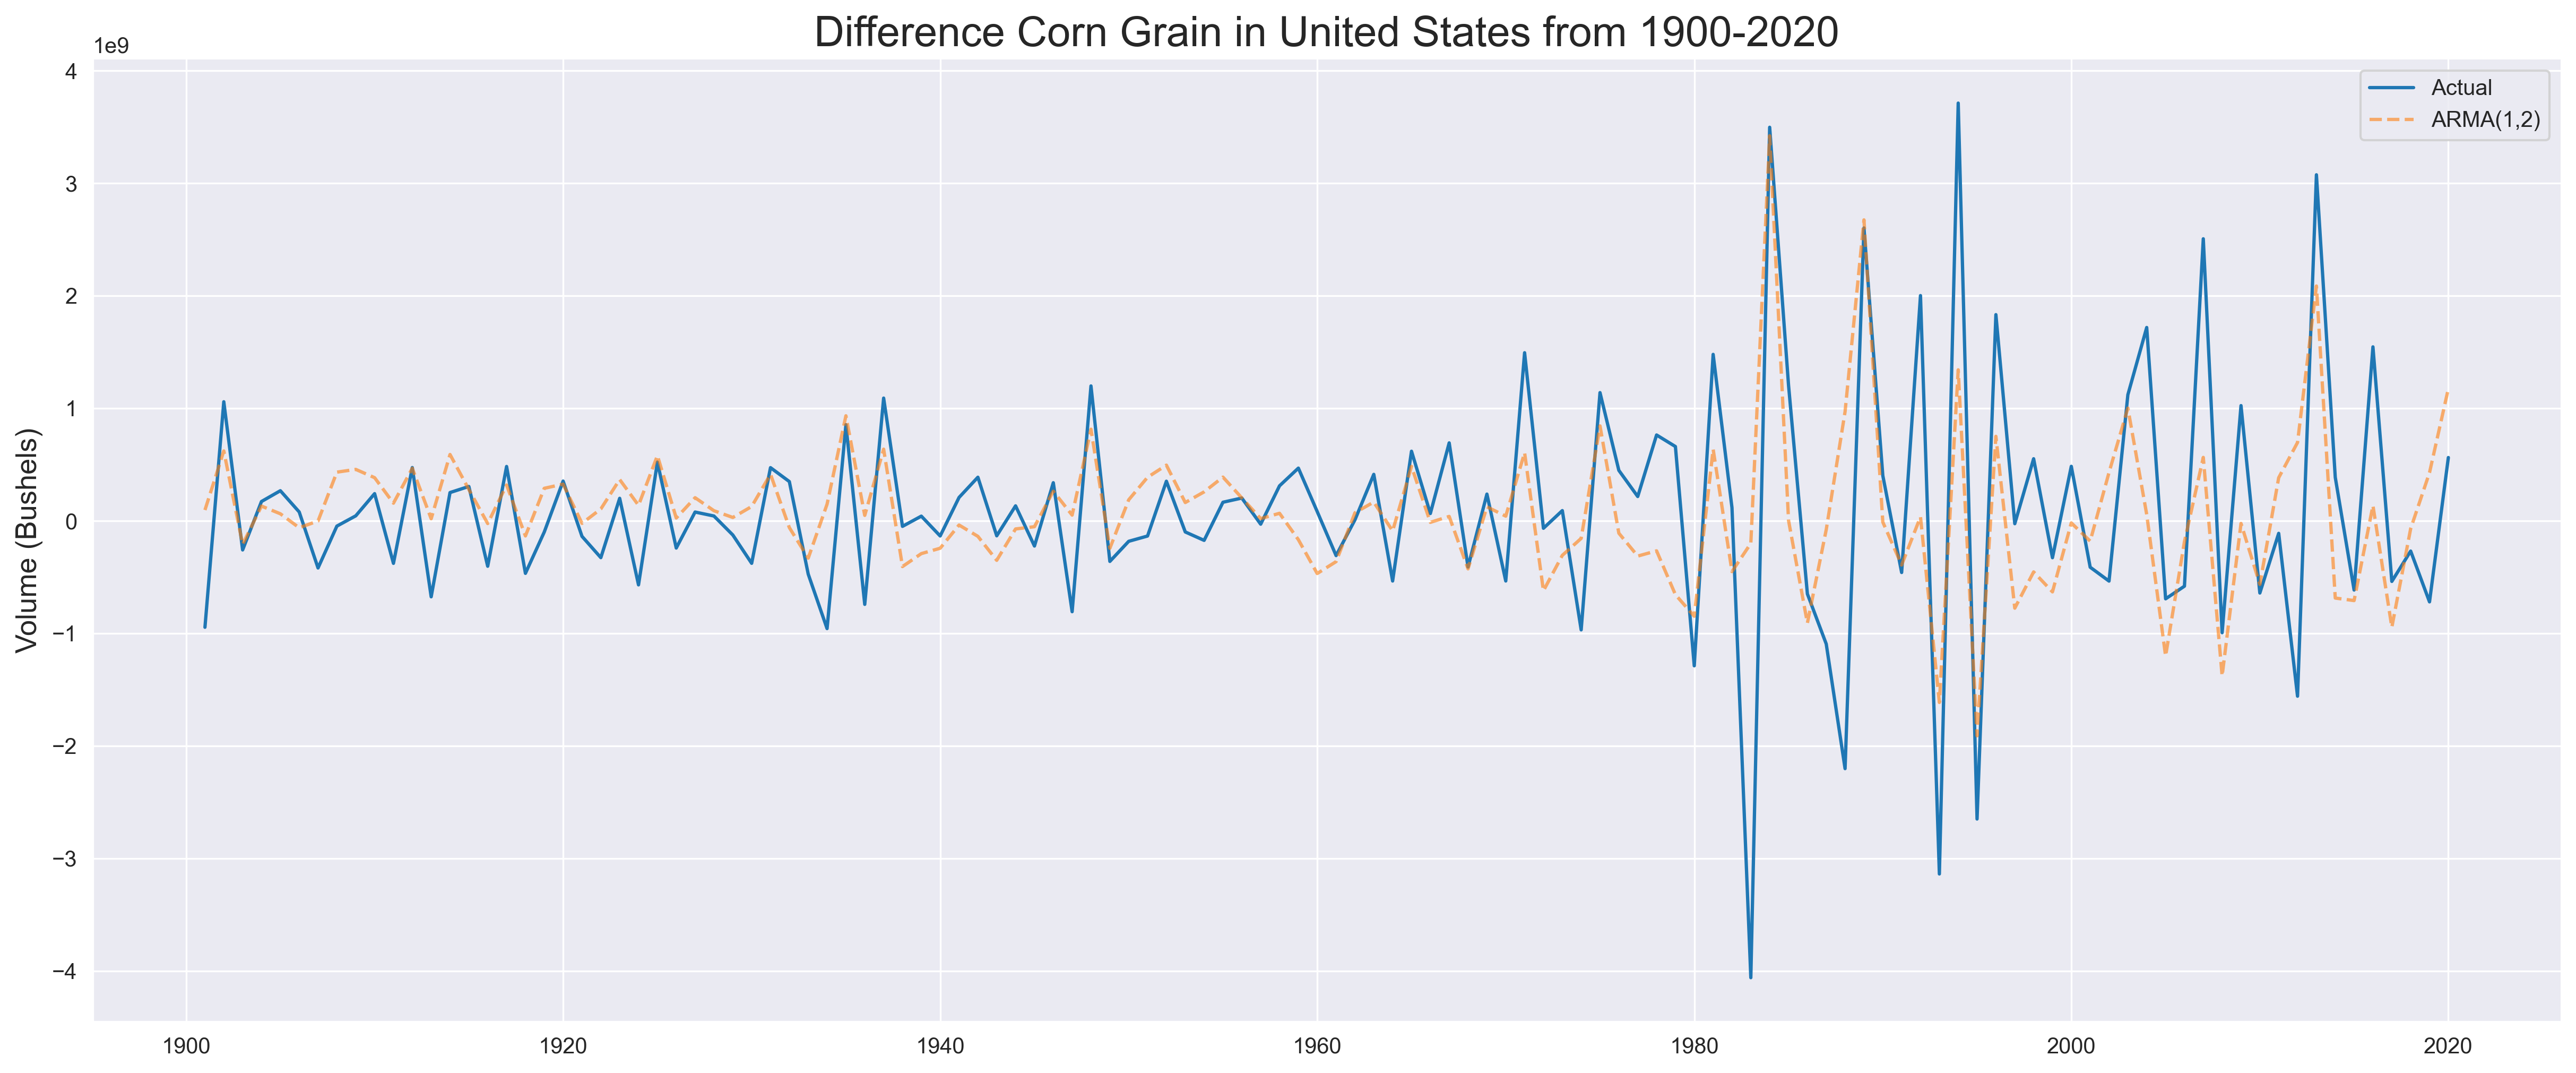

In [41]:
# Plotting the data
fig, ax = plt.subplots(figsize = (20,8), dpi = 300)
plt.plot(df['Value'].diff(periods = 1), label = 'Actual')
plt.plot(result_arma_best.fittedvalues, alpha = 0.6, label = 'ARMA(1,2)', linestyle = '--')

# Plot Settings
plt.legend()
plt.title('Difference Corn Grain in United States from 1900-2020', fontsize = 19)
plt.ylabel('Volume (Bushels)', fontsize = 13)
sns.despine()

The plot above indicates the capability of the model in capturing the differenced data with respect of time. The **ARMA $(1,2)$** have decent capability of following the differenced data. We can see that this model follows the differenced data better than **ARMA $(1,1)$**. We will now use the differenced model's fitted values and use the a formula in **IV.3.1.** and compare it to the pre-differenced data.

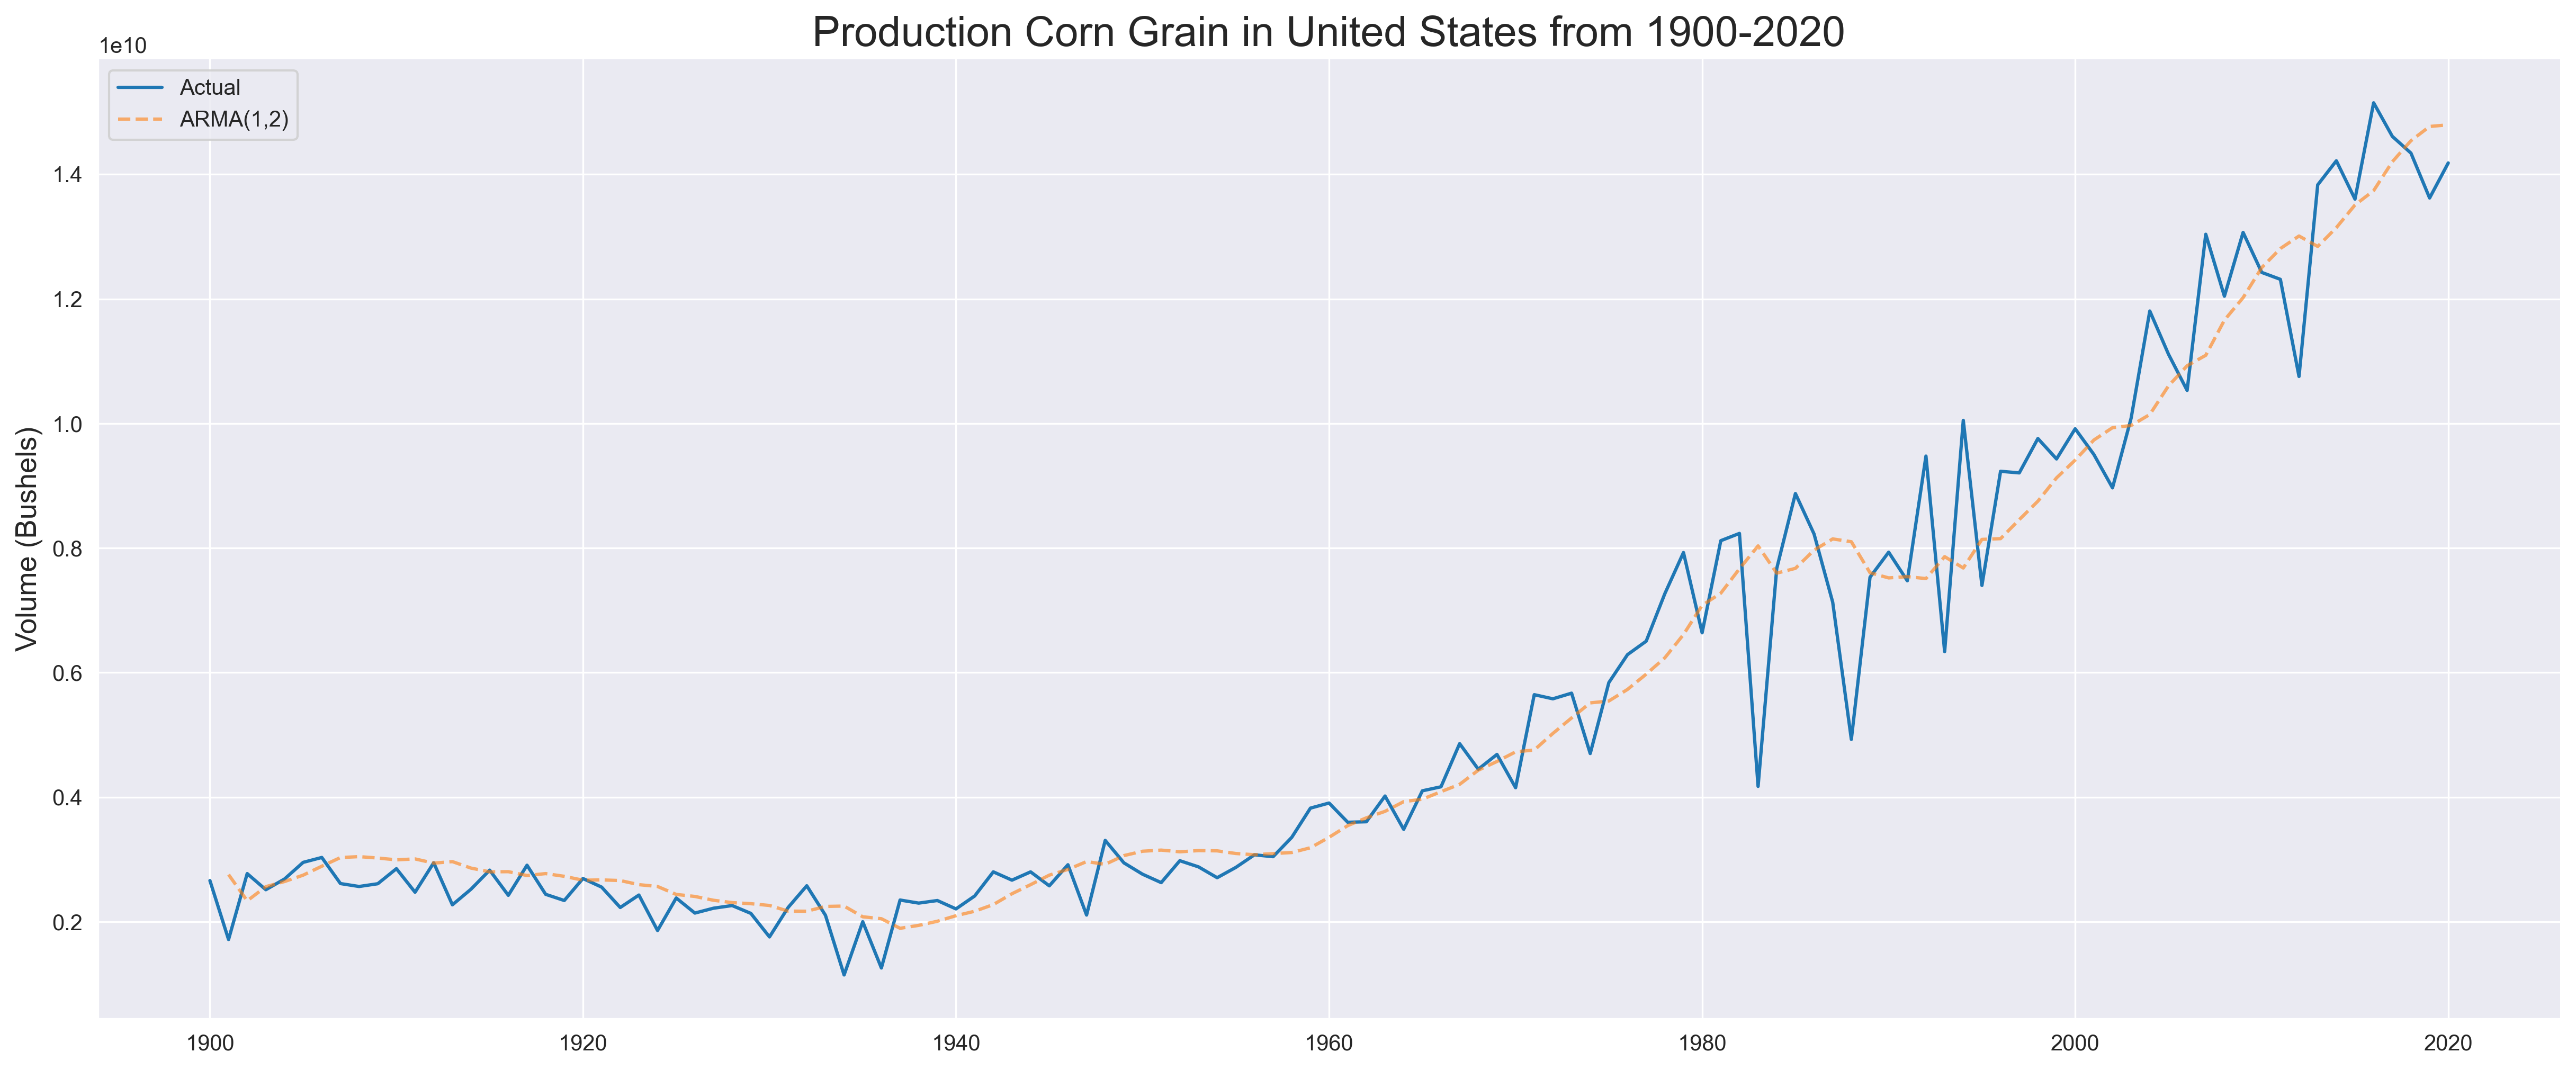

In [42]:
# Appending the predicted value to the dataframe
df['pred_arma_best'] = result_arma_best.fittedvalues + df.Value.shift(1)

# Plotting the data
fig, ax = plt.subplots(figsize = (20,8), dpi = 300)
plt.plot(df['Value'], label = 'Actual')
plt.plot(df['pred_arma_best'], alpha = 0.6, label = 'ARMA(1,2)', linestyle = '--')

# Plot Settings
plt.legend()
plt.title('Production Corn Grain in United States from 1900-2020', fontsize = 19)
plt.ylabel('Volume (Bushels)', fontsize = 13)
sns.despine()

When used the formula and plotted the result, we see that the model follows the trend very well indeed, but it does struggle in capturing the rapidly changing data points such as sudden increase or sudden drops. We will now check the **Correlelogram** of the residuals.

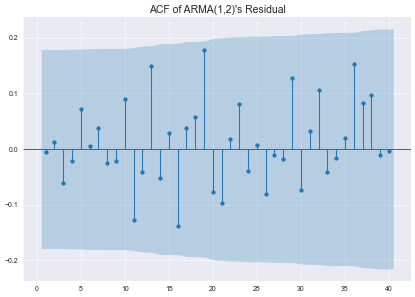

In [43]:
# Plotting the Residual of ARMA Residual
fig, (ax1) = plt.subplots(1,1,figsize = (10,7), dpi = 50)
sgt.plot_acf(result_arma_best.resid, zero = False, lags = 40, ax = ax1)

# Plot settings
plt.title("ACF of ARMA(1,2)'s Residual",size = 15)
sns.despine()
plt.show()

We can also see from the **Autocorrelation Function** plot of the residuals that our errors are not autocorrelated to each other. Next we will check the **Root Mean Squared Error** , **Mean Absolute Error Percentage**, **Akaike Information Criterion** and **Bayesian Information Criterion** metrics to compare the model.

In [44]:
# Calculating the MSE and RMSE
rmse_arma_best = (mean_squared_error(df.Diff.dropna(), result_arma_best.fittedvalues))**0.5

# Printing the result
print('RMSE  : {}'.format(rmse_arma_best))

# Calculating the MAPE
mape_arma_best = np.mean(abs((df.Value[1:] - df.pred_arma_best[1:]))*100/df.Value[1:])
print('MAPE  : {}'.format(mape_arma_best))

# Calculating AIC
aic_arma_best = result_arma_best.aic
print('AIC   : {}'.format(aic_arma_best))
 
# Calculating BIC
bic_arma_best = result_arma_base.bic
print('BIC   : {}'.format(bic_arma_best))

RMSE  : 822131654.9282231
MAPE  : 12.363417411872742
AIC   : 5277.659081060778
BIC   : 5294.634285570585


The **Root Mean Squared Error** for the **ARMA $(1,2)$** is $822,131,658.89$ which might seem a lot, but the target of the model itself is in the billions. Our **Mean Absolute Percentage Error** using the Holt's is roughly $12.36\%$. The **AIC** score for this model is $5,277.659$ and **BIC** is $5,294.634$. We will now plot the distribution of **ARMA $(1,2)$** residuals and check its stationarity using the **Augmented Dickey-Fuller test**.

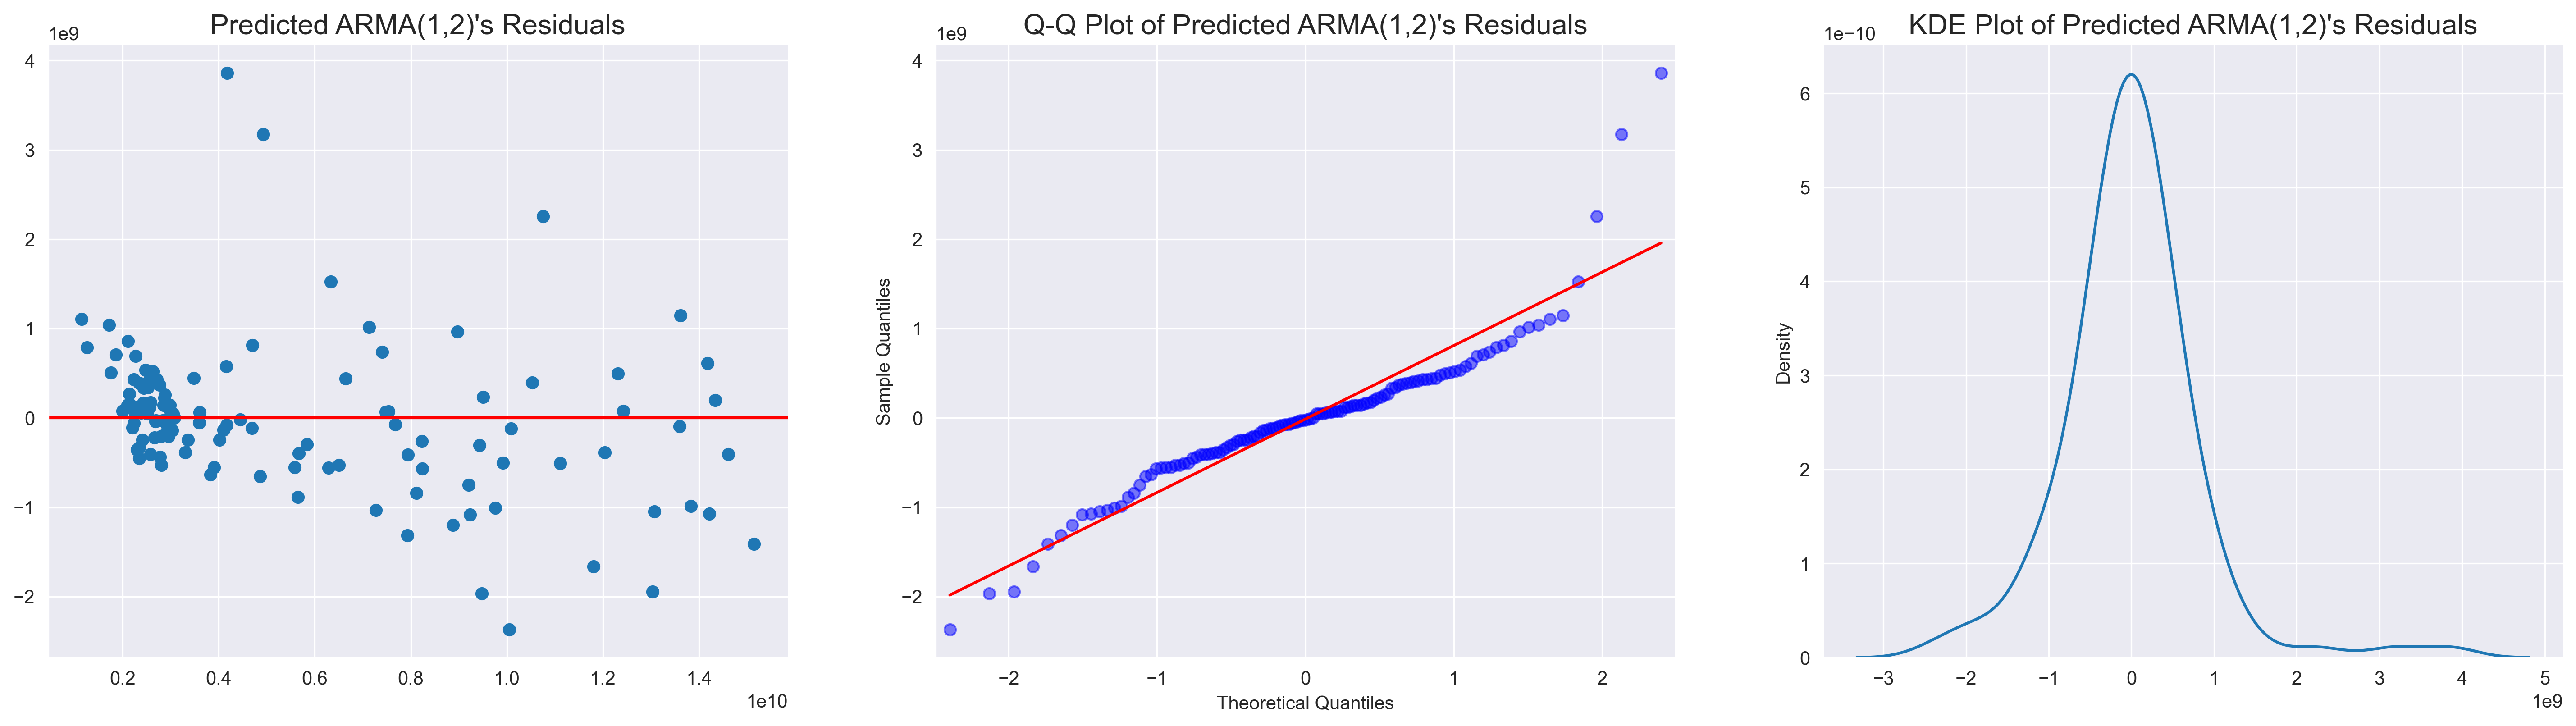

In [45]:
# Plotting the distribution of ARMA(1,2) Residuals
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (24,6), dpi = 300)
ax1.scatter(df['Value'][1:],(df['pred_arma_best'] - df['Value'])[1:])
sm.qqplot((df['pred_arma_best'] - df['Value'])[1:], line="s",ax=ax2,alpha=0.5)
sns.kdeplot((df['pred_arma_best'] - df['Value'])[1:], ax = ax3)

# Plot settings
ax1.set_title("Predicted ARMA(1,2)'s Residuals",size = 15)
ax1.axhline(0, color = 'red')
ax2.set_title("Q-Q Plot of Predicted ARMA(1,2)'s Residuals",fontsize=15)
ax3.set_title("KDE Plot of Predicted ARMA(1,2)'s Residuals", fontsize=15)
sns.despine()

In [46]:
# Checking whether the error is white noise
print('The p-value of the Augmented Dickey-Fuller test is {}'.format(sts.adfuller(result_arma_best.resid[1:])[1]))

The p-value of the Augmented Dickey-Fuller test is 2.7559607377502926e-19


We can see from the plots above, we can see that our residuals of the **ARMA $(1,2)$** almost resembles a normally distributed data, but it has a slight skew to the right and fat-tails at the end on the distribution. We can also see that relative to the actual values, the residuals does not follow a certain patern. The **Augmented Dickey Fuller test** indicates that the residuals is indeed stationary (based on the $\text{p-value}\approx 0$). We will use the **LLR test** function to see whether this model is indeed an improvement from the base model (**ARMA $(1,1)$**).

In [47]:
# LLR Test ARMA(1,1) and ARMA(1,2)
print("LLR test p-value = " + str(LLR_test(result_arma_base, result_arma_best, DF = 1)))

LLR test p-value = 0.005


The **LLR test** result is the $P\text{-value} = 0.005$ which is less than the $\alpha = 0.05$, thus it can be said that the **ARMA $(1,2)$** is a better model than **ARMA $(1,1)$**. Since we also implement this kind of testing in the function to find the best parameters, it is safe to assume that **ARMA $(1,2)$** is the best model given our condition.

## V. Model Selection

### V.1. Comparing the Fitted Results
We will now be comparing two models for our data, those models are **Holt's Exponential Smoothing** and **ARMA $(1,2)$**. The first comparison will be how the models fit our data and capture its nuances. In addition to that, we will see how the model forecast the next 10 entries of our data.

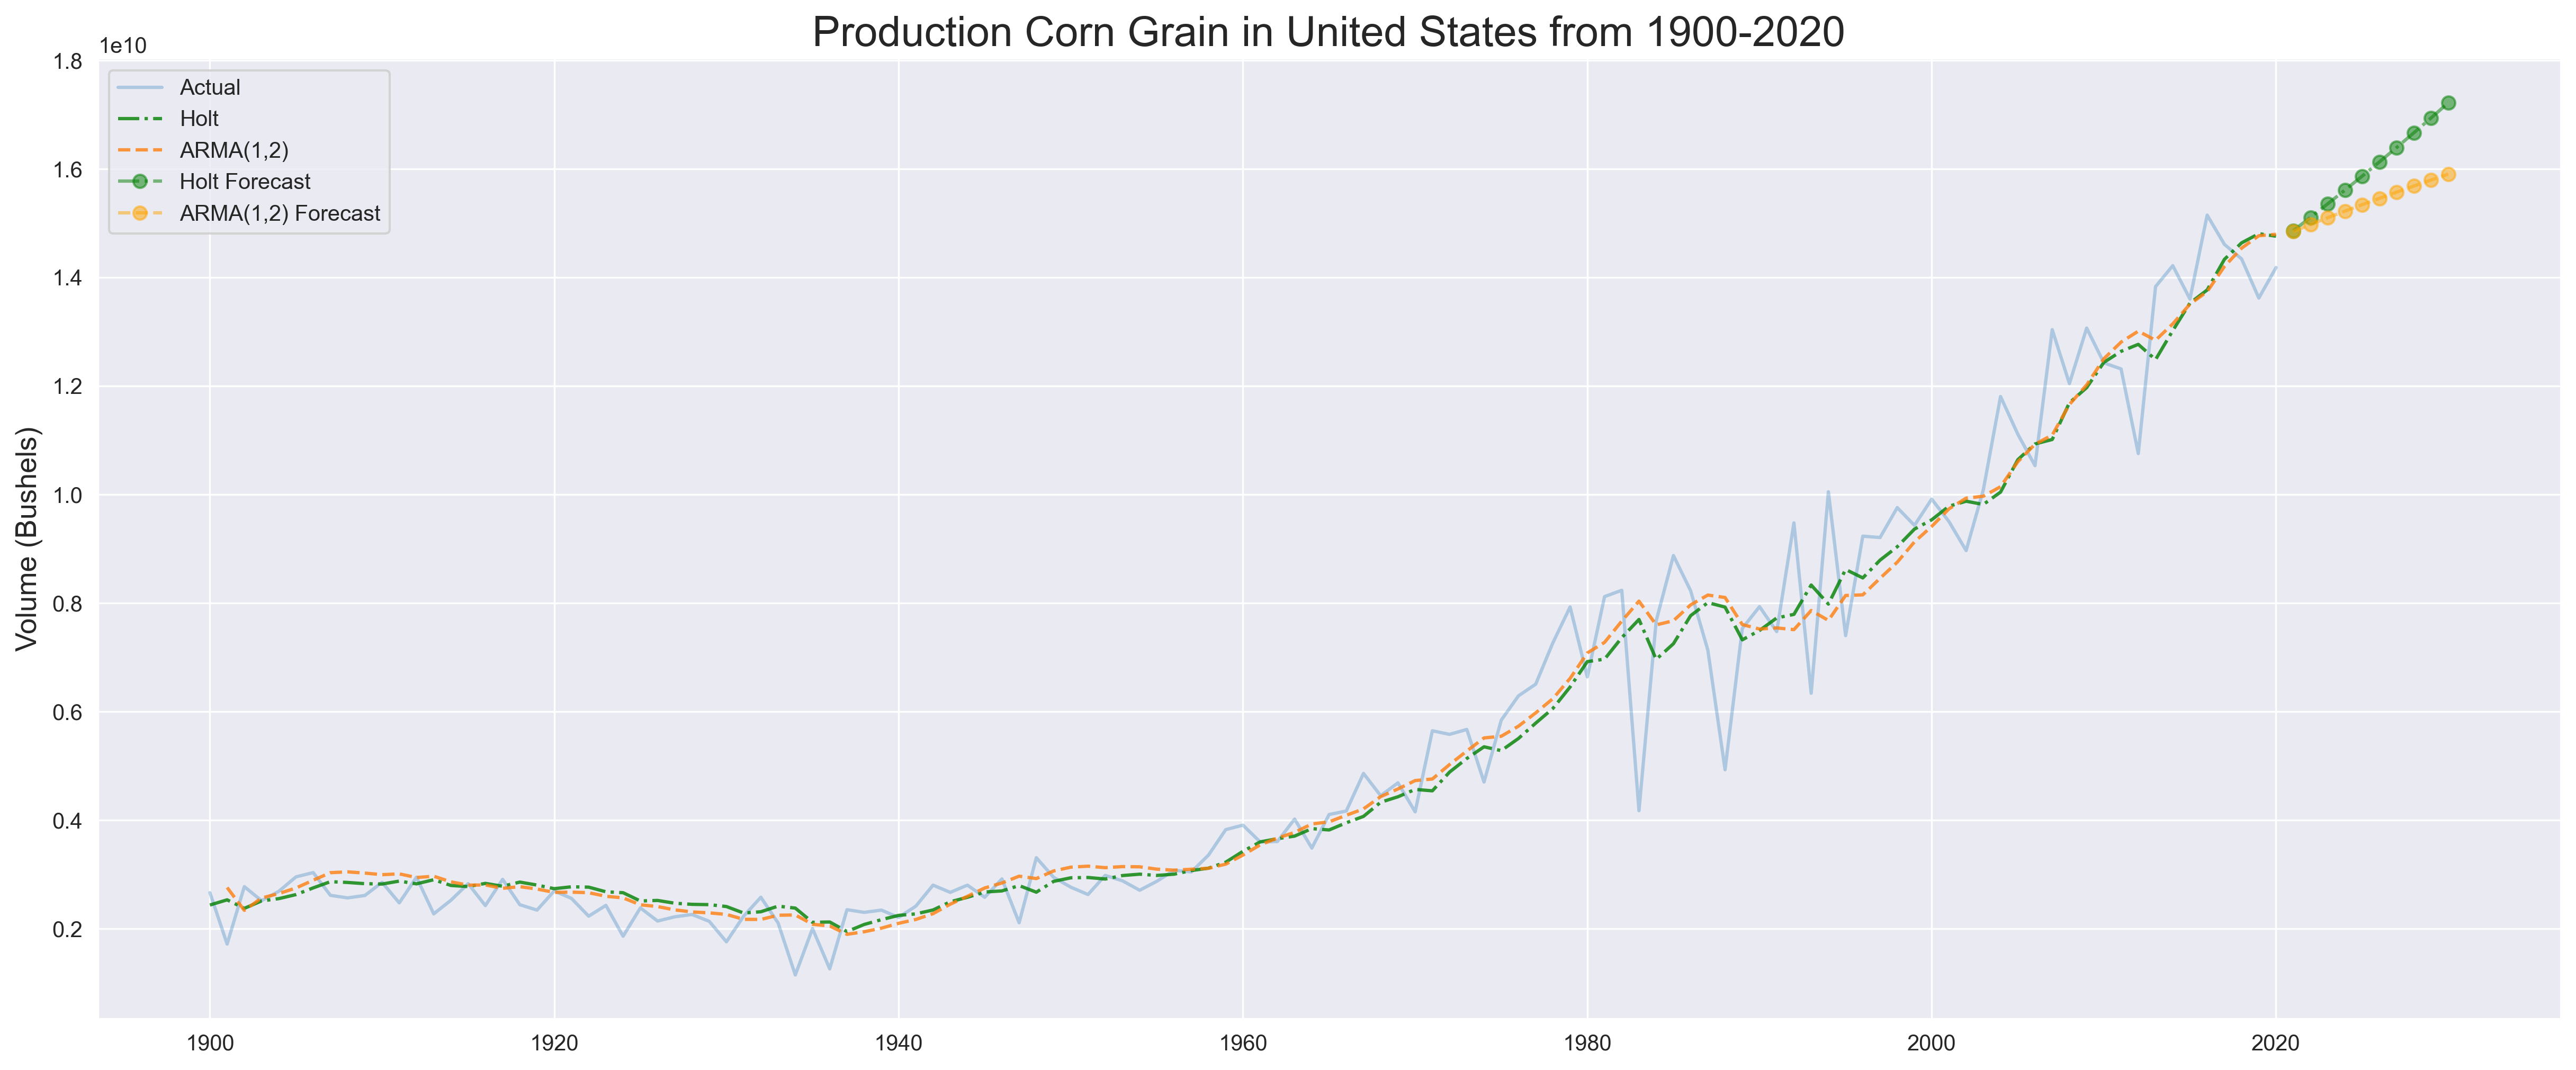

In [48]:
# Holt forecast
holt_forecast = df['Holt'].append(double.forecast(10))

# ARMA(1,2) forecast
clean = list()
initial = int(df.Value.iloc[len(df)-1:])
for i in range(len(result_arma_best.forecast(10)[0])):
    hasil = initial + result_arma_best.forecast(10)[0][i]
    clean.append(hasil)
    initial = hasil

# Plotting the data
fig, ax = plt.subplots(figsize = (20,8), dpi = 300)
plt.plot(df['Value'], label = 'Actual' , alpha = 0.3)
plt.plot(df['Holt'], label = 'Holt', alpha = 0.8, linestyle = '-.', color = 'green')
plt.plot(df['pred_arma_best'], alpha = 0.8, label = 'ARMA(1,2)', linestyle = '--')
plt.plot(double.forecast(10), label = 'Holt Forecast', linestyle = '-.', color = 'green', alpha = 0.5, marker='o')
plt.plot([pd.datetime(2020 + i, 1,1) for i in range(1,11)], clean, 
        label = 'ARMA(1,2) Forecast', linestyle = '--', alpha = 0.5, marker='o', color = 'orange')

# Plot Settings
plt.legend()
plt.title('Production Corn Grain in United States from 1900-2020', fontsize = 19)
plt.ylabel('Volume (Bushels)', fontsize = 13)
sns.despine() 

We can see that more often than not, the fitted values from the **ARMA $(1,2)$** tend to be a little bit higher compared to **Holt's Exponential Smoothing**. We can also see that both model generally follows similar path and are both able to capture the trend in our dataset. What they are both lacking is the capability of following rapid changes in the data, especially data post-1980's.

### V.2. Error Distribution Comparison
We will now compare the residuals for both models, what we are expecting is a normally distributed residuals, although that itself is not a must. We can see the normality using the **Q-Q plot** as well as the **Kernel Density plot**. We can also check the normality of the errors by using the **D'Agostino's K-Squared test**.

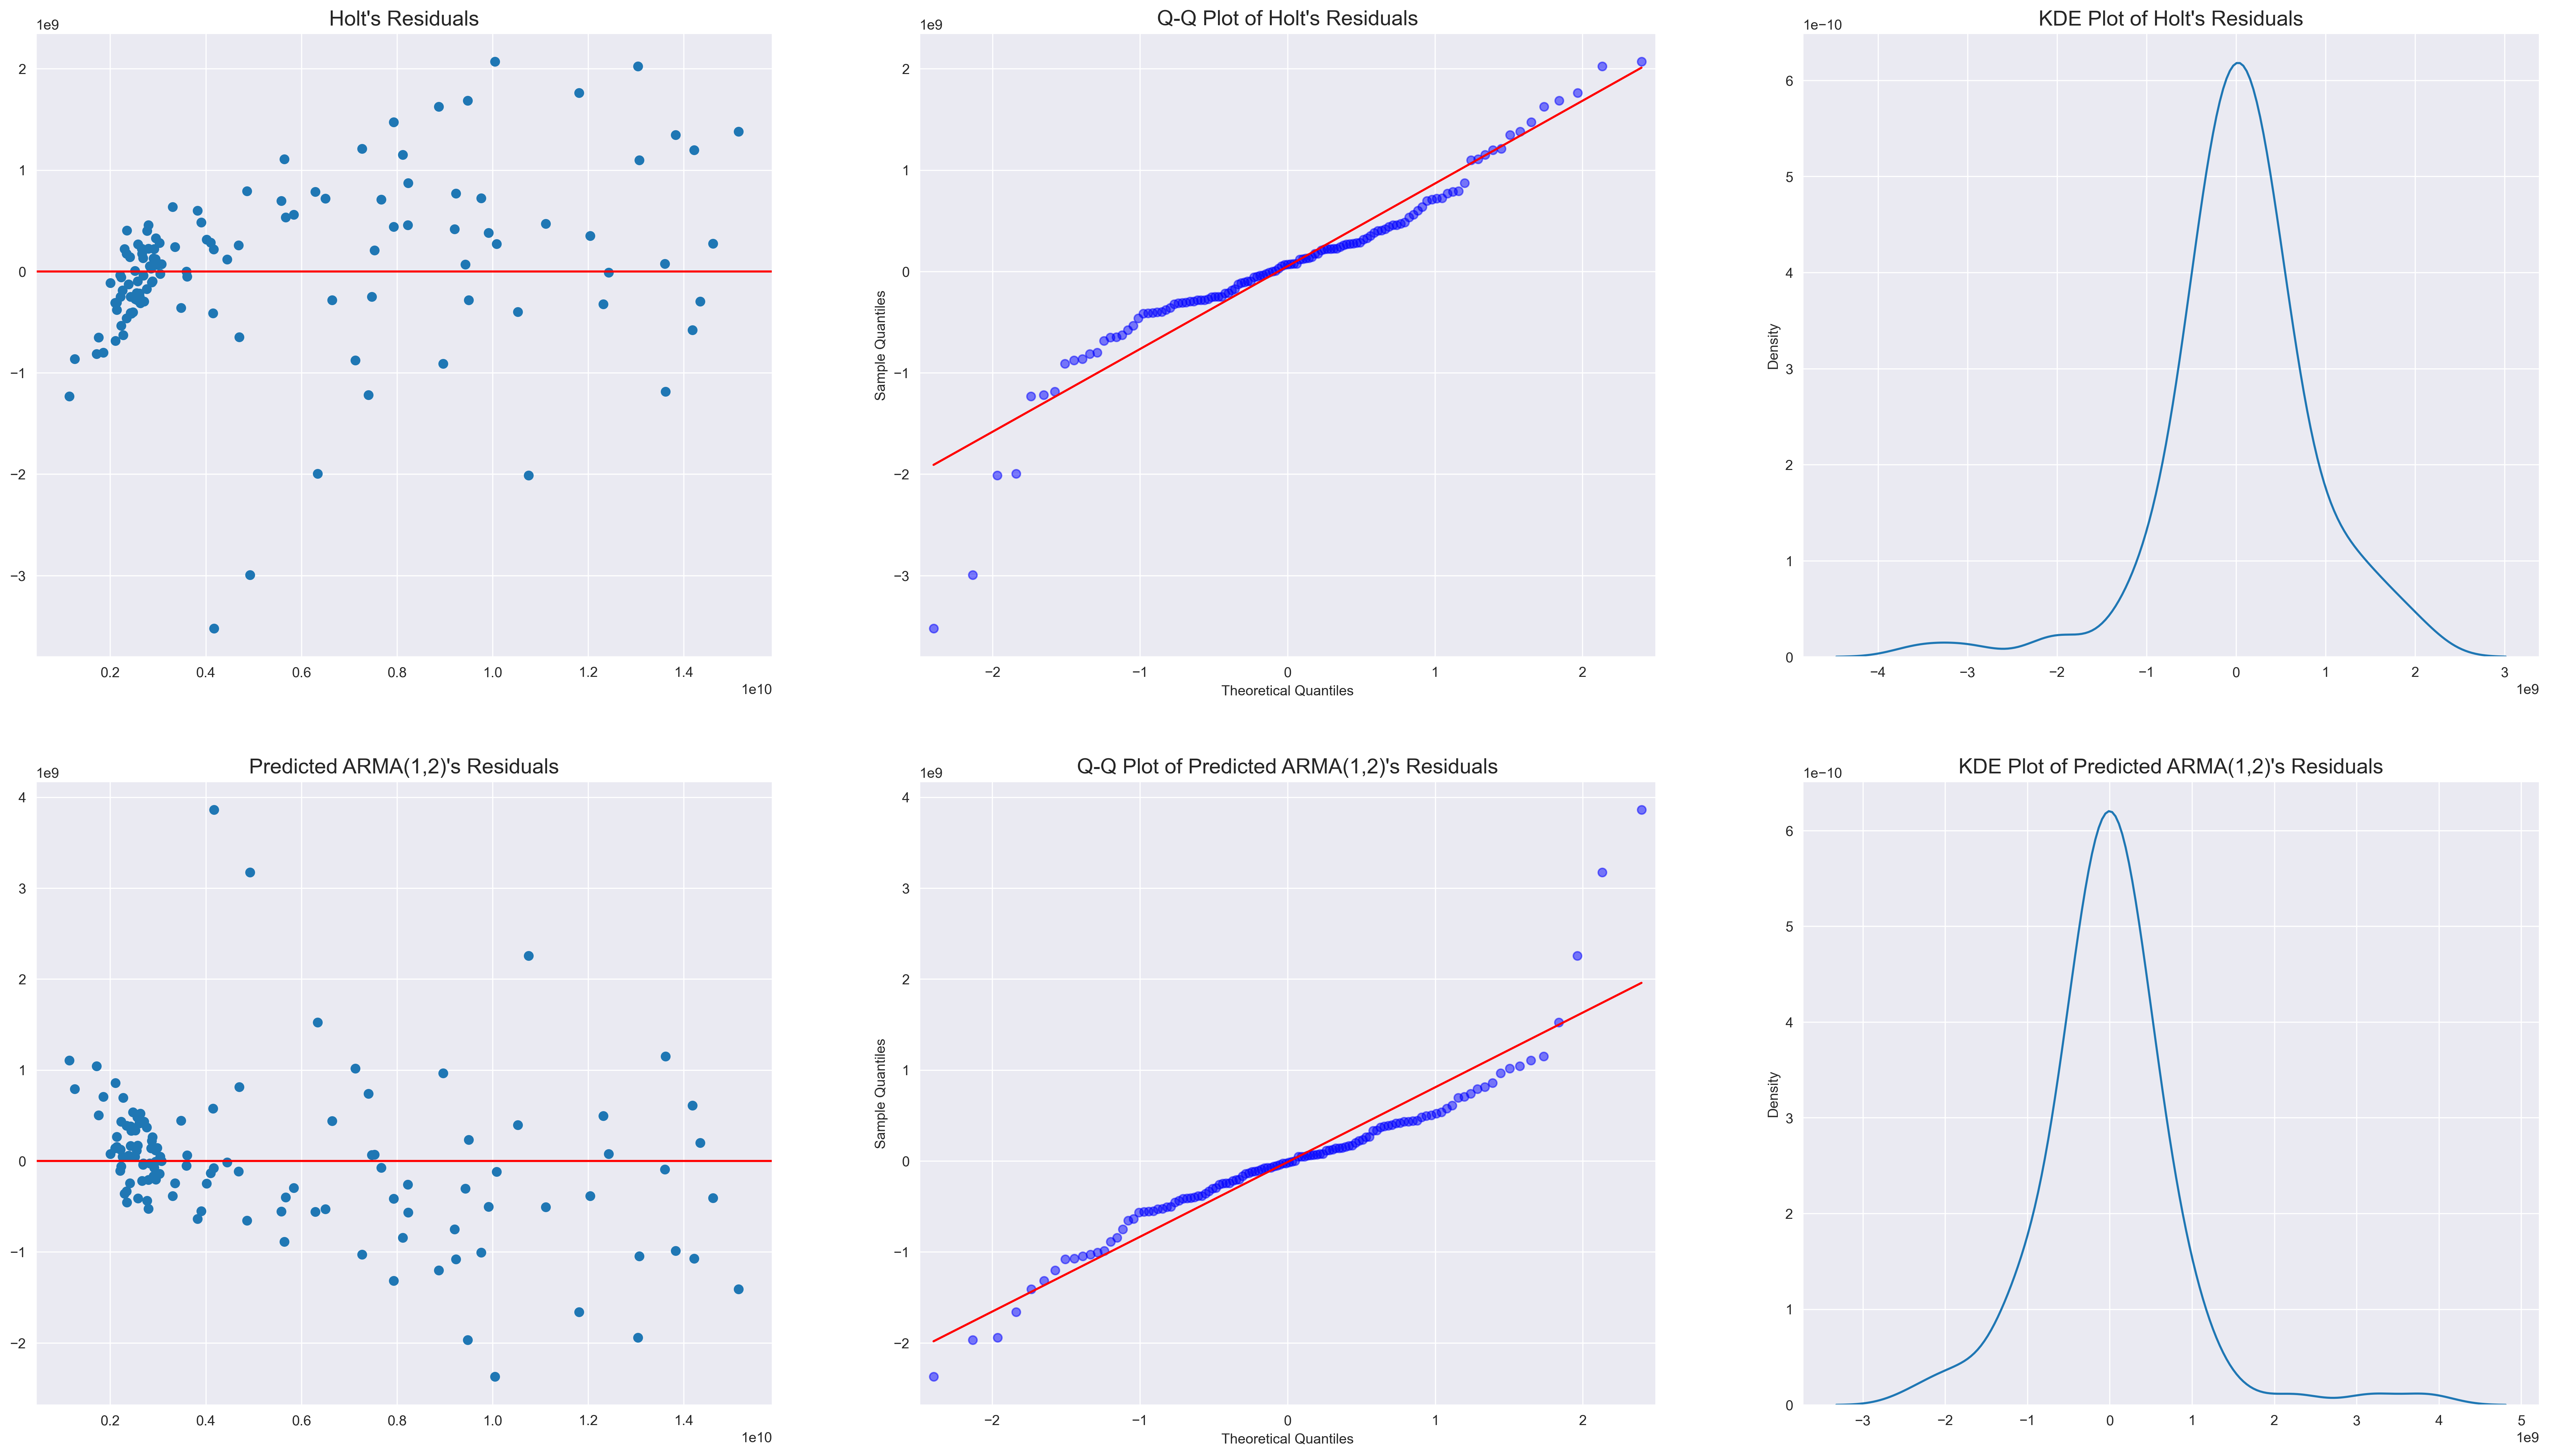

In [49]:
# Setting up the subplots
fig, axs = plt.subplots(2,3,figsize = (32,18), dpi = 300)

# Plotting the distribution of Holt Residuals
axs[0,0].scatter(df['Value'],(double.resid))
sm.qqplot((double.resid), line="s",ax = axs[0,1],alpha=0.5)
sns.kdeplot((double.resid), ax = axs[0,2])

# Plot settings for Holt Residuals
axs[0,0].set_title("Holt's Residuals",size = 15)
axs[0,0].axhline(0, color = 'red')
axs[0,1].set_title("Q-Q Plot of Holt's Residuals",fontsize=15)
axs[0,2].set_title("KDE Plot of Holt's Residuals", fontsize=15)

# Plotting the distribution of ARMA(1,2) Residuals
axs[1,0].scatter(df['Value'][1:],(df['pred_arma_best'][1:] - df['Value'])[1:])
sm.qqplot((df['pred_arma_best'][1:] - df['Value'])[1:], line="s",ax = axs[1,1],alpha=0.5)
sns.kdeplot((df['pred_arma_best'][1:] - df['Value'])[1:], ax = axs[1,2])

# Plot settings for ARMA(1,2) residuals
axs[1,0].set_title("Predicted ARMA(1,2)'s Residuals",size = 15)
axs[1,0].axhline(0, color = 'red')
axs[1,1].set_title("Q-Q Plot of Predicted ARMA(1,2)'s Residuals",fontsize=15)
axs[1,2].set_title("KDE Plot of Predicted ARMA(1,2)'s Residuals", fontsize=15)

plt.show()

From the plots above we can see how the errors are distributed. The errors for both models does not exhibit a clear cut pattern for any fitted values (the input), something which is good to see. On the other hand we can see the normality for both model's residuals. **Holt's Exponential Smoothing** appears to have heavier tails on the left while **ARMA$(1,2)$** have more on the right tail. We can also see that from both the **Q-Q plots** and the **Kernel Density plots**, the errors appear to be normally distributed.

As mentioned above, we will now check the normality of the errors using the **D'Agostino's K-Squared test**, a test of normality based on skewness and kurtosis. The hypothesis we are testing is:

<b>Hypothesis testing for normality:</b><br>
$$H_{0}: \text{The errors are normaly distributed}$$ <br>
$$H_{a}: \text{The errors are not normaly distributed}$$ <br>
<b>Decision Rule:</b> <br> 
$H_{0}$ is rejected if $P\text{-value (D'Agostino's K-Squared test)} < \alpha = 0.05$. <br>

We will be using the `normaltest()` function available from `scipy.stats`.

In [50]:
# Calculating D'Agostino's test for the residuals
print("D’Agostino’s K-Squared test result:\n - Holt's Residual P-Value       =  {a}\n - ARMA(1,2)'s Residual P-value  =  {b}".format(
                                                                        a = normaltest(double.resid)[1],
                                                                        b = normaltest(df['pred_arma_best'][1:] - df['Value'][1:])[1])
                                                                        )

D’Agostino’s K-Squared test result:
 - Holt's Residual P-Value       =  2.553125404801242e-07
 - ARMA(1,2)'s Residual P-value  =  3.944833486797664e-09


In [51]:
# Checking the skew and kurtosis for Holt
print("Skew for Holt's Residual {a}, Kurtosis for Holt's Residual {b}".format(
                                                                a = skew(double.resid),
                                                                b = kurtosis(double.resid, fisher = False)
                                                                )
                                                            )

# Checking the skew and kurtosis for ARMA(1,2)
print("Skew for ARMA(1,2)'s Residual {a}, Kurtosis for ARMA(1,2)'s Residual {b}".format(
                                                                a = skew(df['pred_arma_best'][1:] - df['Value'][1:]),
                                                                b = kurtosis(df['pred_arma_best'][1:] - df['Value'][1:], fisher = False)
                                                                )
                                                            )


Skew for Holt's Residual -0.8618704907276976, Kurtosis for Holt's Residual 6.908021723148563
Skew for ARMA(1,2)'s Residual 1.0115630269210056, Kurtosis for ARMA(1,2)'s Residual 8.297720333738699


We can see from the test above that our residuals are not normally distributed. According to [SPCforexcel](https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics#:~:text=So%2C%20a%20normal%20distribution%20will,sizes%20of%20the%20two%20tails.&text=If%20the%20kurtosis%20is%20greater,(more%20in%20the%20tails)), a normal distribution should have a skew of 0 and a kurtosis of 3. This might be due to the high kurtosis for both residuals despite having a moderately skewed residual for **Holt's Exponential Smoothing** and a somewhat highly-skewed one for **ARMA$(1,2)$**. 

As normality is not a must in time-series analysis, this is not that big of an issue. As a reminder, we have checked the stationarity of the both models using the **Augmented Dickey-Fuller test** and the result is that both models have stationary residuals. The result of the test can also be seen below.

In [52]:
# Checking whether the error is white noise
print('The p-value of the Augmented Dickey-Fuller test for Holt is {}'.format(sts.adfuller(double.resid)[1]))

# Checking whether the error is white noise
print('The p-value of the Augmented Dickey-Fuller test for ARMA(1,2)is {}'.format(sts.adfuller(result_arma_best.resid[1:])[1]))

The p-value of the Augmented Dickey-Fuller test for Holt is 2.3966759793800532e-21
The p-value of the Augmented Dickey-Fuller test for ARMA(1,2)is 2.7559607377502926e-19


### V.3. Model Performance Metrics
As the title sugests, we are going to check some performance metrics of both models. The metrics we are checking are:
- **Root Mean Squared Error**
- **Mean Absolute Percentage Error**
- **Akaike Information Criterion**
- **Bayesian Information Criterion**

In [53]:
# Printing the RMSE for both candidates
print('The Root Mean Squared Error of Holt is {}'.format(rmse_double))
print('The Root Mean Squared Error of ARMA(1,2) is {}'.format(rmse_arma_best))

The Root Mean Squared Error of Holt is 818114044.7813385
The Root Mean Squared Error of ARMA(1,2) is 822131654.9282231


In [54]:
# Printing the MAPE for both candidates
print('The Mean Absolute Percentage Error of Holt is {}'.format(mape_double))
print('The Mean Absolute Percentage Error of ARMA(1,2) is {}'.format(mape_arma_best))

The Mean Absolute Percentage Error of Holt is 12.518547070058409
The Mean Absolute Percentage Error of ARMA(1,2) is 12.363417411872742


In [55]:
# Printing the AIC for both candidates
print('The AIC of Holt is {}'.format(aic_double))
print('The AIC of ARMA(1,2) is {}'.format(aic_arma_best))

The AIC of Holt is 4974.447977543117
The AIC of ARMA(1,2) is 5277.659081060778


In [56]:
# Printing the BIC for both candidates
print('The BIC of Holt is {}'.format(bic_double))
print('The BIC of ARMA(1,2) is {}'.format(bic_arma_best))

The BIC of Holt is 4985.631139725504
The BIC of ARMA(1,2) is 5294.634285570585


||RMSE|MAPE|AIC|BIC|
|---|---|---|---|---|
|**Holt's**|818114044.78|12.52|4974.45|4985.63|
|**ARMA$(1,2)$**|822131658.88|12.36|5277.66|5294.63|

<Br>We can see from the table above that generally the **Holt's Exponential Smoothing** performs better compared to **ARMA$(1,2)$**. The only metric in which the **ARMA$(1,2)$** performs better is **Mean Absolute Percentage Error**.

## VI. Conclusion
The best model to predict corn grain production in United States from the year 1980 to 2020 is **Holt's Exponential Smoothing** whith $\alpha \approx 0.2407$ and $\beta = 0.0001$. This model has the best **Root Mean Squared Error**, the lowest **Akaike Information Criterion** and **Bayesian Information Criterion**. According to the **D'Augostino's K-Squared test**, the residuals for this model is not normally distributed, which can also be confirm by looking at the skew and also the kurtosis of the residuals, but the residuals are indeed stationary. The residuals are also not autocorrelated at any lag. 

## References:
- [AIC vs. BIC](https://www.methodology.psu.edu/resources/AIC-vs-BIC/)
- [A new metric of absolute percentage error for intermittent demand forecasts](https://www.sciencedirect.com/science/article/pii/S0169207016000121#br000015)
- [Are the Skewness and Kurtosis Useful Statistics?](https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics#:~:text=So%2C%20a%20normal%20distribution%20will,sizes%20of%20the%20two%20tails.&text=If%20the%20kurtosis%20is%20greater,(more%20in%20the%20tails))
- [Britanica Encyclopedia : Corn](https://www.britannica.com/plant/corn-plant)
- [Understanding Q-Q Plots](https://data.library.virginia.edu/understanding-q-q-plots/#:~:text=The%20Q%2DQ%20plot%2C%20or%20quantile,as%20a%20Normal%20or%20exponential.&text=If%20both%20sets%20of%20quantiles,a%20line%20that's%20roughly%20straight.)
- [Q-Q Plots Explained](https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0)
- [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)
- [How to Decompose Time Series Data into Trend and Seasonality](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)
- [In: Corn Crop Production Growth, Fertilization and Yield CORN CROP PRODUCTION: GROWTH, FERTILIZATION AND YIELD](https://www.researchgate.net/publication/232252185_In_Corn_Crop_Production_Growth_Fertilization_and_Yield_CORN_CROP_PRODUCTION_GROWTH_FERTILIZATION_AND_YIELD)
- [Interpreting ARMA model results in Statsmodels for absolute beginners](https://medium.com/analytics-vidhya/interpreting-arma-model-results-in-statsmodels-for-absolute-beginners-a4d22253ad1c)
- [Likelihood Ratio Tests](https://www.ibm.com/docs/en/spss-statistics/27.0.0?topic=model-likelihood-ratio-tests)
- [Time Series Analysis: Identifying AR and MA using ACF and PACF Plots](https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8)
- [Time-Varying Volatility](https://www.investopedia.com/terms/t/time-varying-volatility.asp)
- [RMSE: Root Mean Square Error](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/)
- [10 Normality Tests in Python (Step-By-Step Guide 2020)](https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=63301a9f-5d6b-4c3a-9d58-9d24b4a0731e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>